# Lab2: Pandas - A tool for analysing data

The present file is partially based on [tutorial](https://github.com/fonnesbeck/statistical-analysis-python-tutorial/find/master) originally written by Christopher Fonnesbeck. 

The notebook contains some exercises as well. If you decide to work on these, let me know when you answer them, so that I can check. Suggested solutions will be added at the end of this notebook after the lab.


# Introduction to Pandas

**pandas** is a Python package providing fast, flexible, and expressive data structures designed to work with *relational* or *labeled* data both. It is a fundamental high-level building block for doing practical, real world data analysis in Python. 

pandas is well suited for:

- Tabular data with heterogeneously-typed columns, as in an SQL table or Excel spreadsheet
- Ordered and unordered (not necessarily fixed-frequency) time series data.
- Arbitrary matrix data (homogeneously typed or heterogeneous) with row and column labels
- Any other form of observational / statistical data sets. The data actually need not be labeled at all to be placed into a pandas data structure


Key features:
    
- Easy handling of **missing data**
- **Size mutability**: columns can be inserted and deleted from DataFrame and higher dimensional objects
- Automatic and explicit **data alignment**: objects can be explicitly aligned to a set of labels, or the data can be aligned automatically
- Powerful, flexible **group by functionality** to perform split-apply-combine operations on data sets
- Intelligent label-based **slicing, fancy indexing, and subsetting** of large data sets
- Intuitive **merging and joining** data sets
- Flexible **reshaping and pivoting** of data sets
- **Hierarchical labeling** of axes
- Robust **IO tools** for loading data from flat files, Excel files, databases, and HDF5
- **Time series functionality**: date range generation and frequency conversion, moving window statistics, moving window linear regressions, date shifting and lagging, etc.

# Part I

## 1. Initialisation

The next few lines import pandas and NumPy; we visited NumPy in Lab 1. 
Recall that to "load" a library, we need to use the **import** command.

You might wonder what the `matplotlib inline` command does. Recall that matplotlib is a library that handles plotting; the concrete purpose of this line is that the plot is displayed in the Jupyter notebook directly below the code cell that produced it. The resulting plots will then also be stored in the notebook document.

In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = [10,8]  # Set default figure size
import requests

## 2. Pandas Data Structures

### Series

A **Series** is a single vector of data (like a NumPy array) with an *index* that labels each element in the vector.

In [2]:
daily_ret = pd.Series(np.random.randn(10), name='daily returns')
daily_ret

0   -0.660925
1    0.636205
2   -0.189268
3   -0.168494
4   -0.356302
5    0.188841
6    1.311198
7    0.740780
8   -1.280070
9   -0.044650
Name: daily returns, dtype: float64

If an index is not specified, a default sequence of integers is assigned as the index. A NumPy array comprises the values of the `Series`, while the index is a pandas `Index` object.

In [3]:
daily_ret.values

array([-0.66092532,  0.63620452, -0.18926752, -0.16849406, -0.35630229,
        0.188841  ,  1.31119759,  0.74078012, -1.28007023, -0.04465004])

In [4]:
daily_ret.index

RangeIndex(start=0, stop=10, step=1)

We can assign meaningful labels to the index, if they are available. Let's consider another (non-financial) setting.

In [5]:
bacteria = pd.Series([632, 1638, 569, 115], 
    index=['Firmicutes', 'Proteobacteria', 'Actinobacteria', 'Bacteroidetes'])
bacteria

Firmicutes         632
Proteobacteria    1638
Actinobacteria     569
Bacteroidetes      115
dtype: int64

These labels can be used to refer to the values in the `Series`.

In [6]:
bacteria['Actinobacteria']

569

In [7]:
bacteria[[name.endswith('bacteria') for name in bacteria.index]]

Proteobacteria    1638
Actinobacteria     569
dtype: int64

Spend a minute checking the syntax in the above line. Notice the use of the **for** command to filter the results.

In [8]:
[name.endswith('bacteria') for name in bacteria.index]

[False, True, True, False]

Notice that the indexing operation preserved the association between the values and the corresponding indices.

We can still use positional indexing if we wish.

In [9]:
bacteria[0]

C:\Users\sofia\AppData\Local\Temp\ipykernel_15060\3591401137.py:1: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  bacteria[0]


632

We can give both the array of values and the index meaningful labels themselves:

In [10]:
bacteria.name = 'counts'
bacteria.index.name = 'phylum'
bacteria

phylum
Firmicutes         632
Proteobacteria    1638
Actinobacteria     569
Bacteroidetes      115
Name: counts, dtype: int64

NumPy's math functions and other operations can be applied to Series without losing the data structure.

In [11]:
np.log(bacteria)

phylum
Firmicutes        6.448889
Proteobacteria    7.401231
Actinobacteria    6.343880
Bacteroidetes     4.744932
Name: counts, dtype: float64

We can also filter according to the values in the `Series`:

In [12]:
bacteria[bacteria>1000]

phylum
Proteobacteria    1638
Name: counts, dtype: int64

A `Series` can be thought of as an ordered key-value store. In fact, we can create one from a `dict`:

In [13]:
bacteria_dict = {'Firmicutes': 632, 'Proteobacteria': 1638, 'Actinobacteria': 569, 'Bacteroidetes': 115}
pd.Series(bacteria_dict)

Firmicutes         632
Proteobacteria    1638
Actinobacteria     569
Bacteroidetes      115
dtype: int64

Notice that the `Series` is created in key-sorted order.

If we pass a custom index to `Series`, it will select the corresponding values from the dict, and treat indices without corresponding values as missing. Pandas uses the `NaN` (not a number) type for missing values.

In [14]:
bacteria2 = pd.Series(bacteria_dict, index=['Cyanobacteria','Firmicutes','Proteobacteria','Actinobacteria'])
bacteria2

Cyanobacteria        NaN
Firmicutes         632.0
Proteobacteria    1638.0
Actinobacteria     569.0
dtype: float64

In [15]:
bacteria2.isnull()

Cyanobacteria      True
Firmicutes        False
Proteobacteria    False
Actinobacteria    False
dtype: bool

Critically, the labels are used to **align data** when used in operations with other Series objects:

In [16]:
bacteria + bacteria2

Actinobacteria    1138.0
Bacteroidetes        NaN
Cyanobacteria        NaN
Firmicutes        1264.0
Proteobacteria    3276.0
dtype: float64

Contrast this with NumPy arrays, where arrays of the same length will combine values element-wise; adding Series combined values with the same label in the resulting series. Notice also that the missing values were propagated by addition.

### DataFrame

Inevitably, we want to be able to store, view and manipulate data that is *multivariate*, where for every index there are multiple fields or columns of data, often of varying data type.

A `DataFrame` is a tabular data structure, encapsulating multiple series like columns in a spreadsheet. Data are stored internally as a 2-dimensional object, but the `DataFrame` allows us to represent and manipulate higher-dimensional data.

In [17]:
data = pd.DataFrame({'value':[632, 1638, 569, 115, 433, 1130, 754, 555],
                     'patient':[1, 1, 1, 1, 2, 2, 2, 2],
                     'phylum':['Firmicutes', 'Proteobacteria', 'Actinobacteria', 
    'Bacteroidetes', 'Firmicutes', 'Proteobacteria', 'Actinobacteria', 'Bacteroidetes']})
data

,value,patient,phylum
0,632,1,Firmicutes
1,1638,1,Proteobacteria
2,569,1,Actinobacteria
3,115,1,Bacteroidetes
4,433,2,Firmicutes
5,1130,2,Proteobacteria
6,754,2,Actinobacteria
7,555,2,Bacteroidetes


Notice the `DataFrame` is sorted by column name. We can change the order by indexing them in the order we desire:

In [18]:
data[['phylum','value','patient']]

,phylum,value,patient
0,Firmicutes,632,1
1,Proteobacteria,1638,1
2,Actinobacteria,569,1
3,Bacteroidetes,115,1
4,Firmicutes,433,2
5,Proteobacteria,1130,2
6,Actinobacteria,754,2
7,Bacteroidetes,555,2


A `DataFrame` has a second index, representing the columns:

In [19]:
data.columns

Index(['value', 'patient', 'phylum'], dtype='object')

If we wish to access columns, we can do so either by dict-like indexing or by attribute:

In [20]:
data['value']

0     632
1    1638
2     569
3     115
4     433
5    1130
6     754
7     555
Name: value, dtype: int64

In [21]:
data.value

0     632
1    1638
2     569
3     115
4     433
5    1130
6     754
7     555
Name: value, dtype: int64

In [22]:
type(data.value)

pandas.core.series.Series

In [23]:
type(data[['value']])

pandas.core.frame.DataFrame

Notice this is different than with `Series`, where dict-like indexing retrieved a particular element (row). If we want access to a row in a `DataFrame`, we index its `iloc` attribute.


In [24]:
data.iloc[3]

value                115
patient                1
phylum     Bacteroidetes
Name: 3, dtype: object

## *Exercise 1*

What do the following commands do?

`data.head()`

`data.tail()`

`data.shape`

## *End of exercise*

Alternatively, we can create a `DataFrame` with a dict of dicts:

In [25]:
data = pd.DataFrame({0: {'patient': 1, 'phylum': 'Firmicutes', 'value': 632},
                    1: {'patient': 1, 'phylum': 'Proteobacteria', 'value': 1638},
                    2: {'patient': 1, 'phylum': 'Actinobacteria', 'value': 569},
                    3: {'patient': 1, 'phylum': 'Bacteroidetes', 'value': 115},
                    4: {'patient': 2, 'phylum': 'Firmicutes', 'value': 433},
                    5: {'patient': 2, 'phylum': 'Proteobacteria', 'value': 1130},
                    6: {'patient': 2, 'phylum': 'Actinobacteria', 'value': 754},
                    7: {'patient': 2, 'phylum': 'Bacteroidetes', 'value': 555}})

In [26]:
data

,0,1,2,3,4,5,6,7
patient,1,1,1,1,2,2,2,2
phylum,Firmicutes,Proteobacteria,Actinobacteria,Bacteroidetes,Firmicutes,Proteobacteria,Actinobacteria,Bacteroidetes
value,632,1638,569,115,433,1130,754,555


We probably want this transposed:

In [27]:
data = data.T
data

,patient,phylum,value
0,1,Firmicutes,632
1,1,Proteobacteria,1638
2,1,Actinobacteria,569
3,1,Bacteroidetes,115
4,2,Firmicutes,433
5,2,Proteobacteria,1130
6,2,Actinobacteria,754
7,2,Bacteroidetes,555


Its important to note that the Series returned when a DataFrame is indexed is merely a **view** on the DataFrame, and not a copy of the data itself. So you must be cautious when manipulating this data:

In [28]:
vals = data.value
vals

0     632
1    1638
2     569
3     115
4     433
5    1130
6     754
7     555
Name: value, dtype: object

In [29]:
vals[5] = 0
vals

0     632
1    1638
2     569
3     115
4     433
5       0
6     754
7     555
Name: value, dtype: object

In [30]:
data

,patient,phylum,value
0,1,Firmicutes,632
1,1,Proteobacteria,1638
2,1,Actinobacteria,569
3,1,Bacteroidetes,115
4,2,Firmicutes,433
5,2,Proteobacteria,0
6,2,Actinobacteria,754
7,2,Bacteroidetes,555


In [31]:
vals = data.value.copy()
vals[5] = 1000
data

,patient,phylum,value
0,1,Firmicutes,632
1,1,Proteobacteria,1638
2,1,Actinobacteria,569
3,1,Bacteroidetes,115
4,2,Firmicutes,433
5,2,Proteobacteria,0
6,2,Actinobacteria,754
7,2,Bacteroidetes,555


We can create or modify columns by assignment:

In [32]:
data.value[3] = 14
data

,patient,phylum,value
0,1,Firmicutes,632
1,1,Proteobacteria,1638
2,1,Actinobacteria,569
3,1,Bacteroidetes,14
4,2,Firmicutes,433
5,2,Proteobacteria,0
6,2,Actinobacteria,754
7,2,Bacteroidetes,555


In [33]:
data['year'] = 2022
data

,patient,phylum,value,year
0,1,Firmicutes,632,2022
1,1,Proteobacteria,1638,2022
2,1,Actinobacteria,569,2022
3,1,Bacteroidetes,14,2022
4,2,Firmicutes,433,2022
5,2,Proteobacteria,0,2022
6,2,Actinobacteria,754,2022
7,2,Bacteroidetes,555,2022


But note, we cannot use the attribute indexing method to add a new column:

In [34]:
data.treatment = 1
data

,patient,phylum,value,year
0,1,Firmicutes,632,2022
1,1,Proteobacteria,1638,2022
2,1,Actinobacteria,569,2022
3,1,Bacteroidetes,14,2022
4,2,Firmicutes,433,2022
5,2,Proteobacteria,0,2022
6,2,Actinobacteria,754,2022
7,2,Bacteroidetes,555,2022


In [35]:
data.treatment

1

## *Exercise 2*
From the data table above, create an index to return all rows for which the phylum name ends in "bacteria" and the value is greater than 1000.
## *End of exercise*

Specifying a `Series` as a new columns cause its values to be added according to the `DataFrame`'s index:

In [44]:
treatment = pd.Series([0]*4 + [1]*2)
treatment

0    0
1    0
2    0
3    0
4    1
5    1
dtype: int64

In [45]:
data['treatment'] = treatment
data

,patient,phylum,value,year,treatment
0,1,Firmicutes,632,2022,0.0
1,1,Proteobacteria,1638,2022,0.0
2,1,Actinobacteria,569,2022,0.0
3,1,Bacteroidetes,14,2022,0.0
4,2,Firmicutes,433,2022,1.0
5,2,Proteobacteria,0,2022,1.0
6,2,Actinobacteria,754,2022,NaN
7,2,Bacteroidetes,555,2022,NaN


Other Python data structures (ones without an index) need to be the same length as the `DataFrame`:

In [46]:
month = ['Jan', 'Feb', 'Mar', 'Apr']
data['month'] = month

ValueError: Length of values (4) does not match length of index (8)

In [47]:
data['month'] = ['Jan']*len(data)
data

,patient,phylum,value,year,treatment,month
0,1,Firmicutes,632,2022,0.0,Jan
1,1,Proteobacteria,1638,2022,0.0,Jan
2,1,Actinobacteria,569,2022,0.0,Jan
3,1,Bacteroidetes,14,2022,0.0,Jan
4,2,Firmicutes,433,2022,1.0,Jan
5,2,Proteobacteria,0,2022,1.0,Jan
6,2,Actinobacteria,754,2022,NaN,Jan
7,2,Bacteroidetes,555,2022,NaN,Jan


We can use `del` to remove columns, in the same way `dict` entries can be removed:

In [48]:
del data['month']
data

,patient,phylum,value,year,treatment
0,1,Firmicutes,632,2022,0.0
1,1,Proteobacteria,1638,2022,0.0
2,1,Actinobacteria,569,2022,0.0
3,1,Bacteroidetes,14,2022,0.0
4,2,Firmicutes,433,2022,1.0
5,2,Proteobacteria,0,2022,1.0
6,2,Actinobacteria,754,2022,NaN
7,2,Bacteroidetes,555,2022,NaN


We can extract the underlying data as a simple `ndarray` by accessing the `values` attribute:

In [49]:
data.values

array([[1, 'Firmicutes', 632, 2022, 0.0],
       [1, 'Proteobacteria', 1638, 2022, 0.0],
       [1, 'Actinobacteria', 569, 2022, 0.0],
       [1, 'Bacteroidetes', 14, 2022, 0.0],
       [2, 'Firmicutes', 433, 2022, 1.0],
       [2, 'Proteobacteria', 0, 2022, 1.0],
       [2, 'Actinobacteria', 754, 2022, nan],
       [2, 'Bacteroidetes', 555, 2022, nan]], dtype=object)

Notice that because of the mix of string and integer (and `NaN`) values, the dtype of the array is `object`. The dtype will automatically be chosen to be as general as needed to accomodate all the columns.

In [50]:
df = pd.DataFrame({'foo': [1,2,3], 'bar':[0.4, -1.0, 4.5]})
df.values

array([[ 1. ,  0.4],
       [ 2. , -1. ],
       [ 3. ,  4.5]])

Pandas uses a custom data structure to represent the indices of Series and DataFrames.

In [51]:
data.index

Index([0, 1, 2, 3, 4, 5, 6, 7], dtype='int64')

Index objects are immutable:

In [52]:
data.index[0] = 15

TypeError: Index does not support mutable operations

This is so that Index objects can be shared between data structures without fear that they will be changed.

In [53]:
bacteria2.index = bacteria.index

In [54]:
bacteria2

phylum
Firmicutes           NaN
Proteobacteria     632.0
Actinobacteria    1638.0
Bacteroidetes      569.0
dtype: float64

## 3. Importing data

A key, but often under-appreciated, step in data analysis is importing the data that we wish to analyse. Though it is easy to load basic data structures into Python using built-in tools or those provided by packages like NumPy, it is non-trivial to import structured data well, and to easily convert this input into a robust data structure:

    genes = np.loadtxt("genes.csv", delimiter=",", dtype=[('gene', '|S10'), ('value', '<f4')])

Pandas provides a convenient set of functions for importing tabular data in a number of formats directly into a `DataFrame` object. These functions include a slew of options to perform type inference, indexing, parsing, iterating and cleaning automatically as data are imported.

Let's start with some more financial/econometrical data, stored in csv format.

In [59]:
!more data_lab2\pwt.csv

"country","country isocode","year","POP","XRAT","tcgdp","cc","cg"
"Argentina","ARG","2000","37335.653","0.9995","295072.21869","75.716805379","5.5788042896"
"Australia","AUS","2000","19053.186","1.72483","541804.6521","67.759025993","6.7200975332"
"India","IND","2000","1006300.297","44.9416","1728144.3748","64.575551328","14.072205773"
"Israel","ISR","2000","6114.57","4.07733","129253.89423","64.436450847","10.266688415"
"Malawi","MWI","2000","11801.505","59.543808333","5026.2217836","74.707624181","11.658954494"
"South Africa","ZAF","2000","45064.098","6.93983","227242.36949","72.718710427","5.7265463933"
"United States","USA","2000","282171.957","1","9898700","72.347054303","6.0324539789"
"Uruguay","URY","2000","3219.793","12.099591667","25255.961693","78.978740282","5.108067988"


This table can be read into a DataFrame using `read_csv`:

In [60]:
mb = pd.read_csv("data_lab2/pwt.csv")
mb

,country,country isocode,year,POP,XRAT,tcgdp,cc,cg
0,Argentina,ARG,2000,37335.653,0.999500,2.950722e+05,75.716805,5.578804
1,Australia,AUS,2000,19053.186,1.724830,5.418047e+05,67.759026,6.720098
2,India,IND,2000,1006300.297,44.941600,1.728144e+06,64.575551,14.072206
3,Israel,ISR,2000,6114.570,4.077330,1.292539e+05,64.436451,10.266688
4,Malawi,MWI,2000,11801.505,59.543808,5.026222e+03,74.707624,11.658954
5,South Africa,ZAF,2000,45064.098,6.939830,2.272424e+05,72.718710,5.726546
6,United States,USA,2000,282171.957,1.000000,9.898700e+06,72.347054,6.032454
7,Uruguay,URY,2000,3219.793,12.099592,2.525596e+04,78.978740,5.108068


Notice that `read_csv` automatically considered the first row in the file to be a header row.

We can override default behavior by customizing some the arguments, like `header`, `names` or `index_col`.

In [62]:
pd.read_csv("data_lab2/pwt.csv", header=None).head()

,0,1,2,3,4,5,6,7
0,country,country isocode,year,POP,XRAT,tcgdp,cc,cg
1,Argentina,ARG,2000,37335.653,0.9995,295072.21869,75.716805379,5.5788042896
2,Australia,AUS,2000,19053.186,1.72483,541804.6521,67.759025993,6.7200975332
3,India,IND,2000,1006300.297,44.9416,1728144.3748,64.575551328,14.072205773
4,Israel,ISR,2000,6114.57,4.07733,129253.89423,64.436450847,10.266688415


`read_csv` is just a convenience function for `read_table`, since csv is such a common format:

In [65]:
mb = pd.read_table("data_lab2/pwt.csv", sep=',')

The `sep` argument can be customized as needed to accomodate arbitrary separators. For example, we can use a regular expression to define a variable amount of whitespace, which is unfortunately very common in some data formats: 
    
    sep='\s+'

For a more useful index, we can specify the ISO-code column, which provides a unique index to the data.

In [67]:
mb = pd.read_csv("data_lab2/pwt.csv", index_col=['country isocode'])
mb.head()

,country,year,POP,XRAT,tcgdp,cc,cg
country isocode,,,,,,,
ARG,Argentina,2000,37335.653,0.999500,2.950722e+05,75.716805,5.578804
AUS,Australia,2000,19053.186,1.724830,5.418047e+05,67.759026,6.720098
IND,India,2000,1006300.297,44.941600,1.728144e+06,64.575551,14.072206
ISR,Israel,2000,6114.570,4.077330,1.292539e+05,64.436451,10.266688
MWI,Malawi,2000,11801.505,59.543808,5.026222e+03,74.707624,11.658954


If we have sections of data that we do not wish to import (for example, known bad data), we can populate the `skiprows` argument:

In [69]:
pd.read_csv("data_lab2/pwt.csv", skiprows=[3,4,6]).head()

,country,country isocode,year,POP,XRAT,tcgdp,cc,cg
0,Argentina,ARG,2000,37335.653,0.999500,2.950722e+05,75.716805,5.578804
1,Australia,AUS,2000,19053.186,1.724830,5.418047e+05,67.759026,6.720098
2,Malawi,MWI,2000,11801.505,59.543808,5.026222e+03,74.707624,11.658954
3,United States,USA,2000,282171.957,1.000000,9.898700e+06,72.347054,6.032454
4,Uruguay,URY,2000,3219.793,12.099592,2.525596e+04,78.978740,5.108068


Conversely, if we only want to import a small number of rows from, say, a very large data file we can use `nrows`:

In [71]:
pd.read_csv("data_lab2/pwt.csv", nrows=4)

,country,country isocode,year,POP,XRAT,tcgdp,cc,cg
0,Argentina,ARG,2000,37335.653,0.99950,2.950722e+05,75.716805,5.578804
1,Australia,AUS,2000,19053.186,1.72483,5.418047e+05,67.759026,6.720098
2,India,IND,2000,1006300.297,44.94160,1.728144e+06,64.575551,14.072206
3,Israel,ISR,2000,6114.570,4.07733,1.292539e+05,64.436451,10.266688


Alternately, if we want to process our data in reasonable chunks, the `chunksize` argument will return an iterable object that can be employed in a data processing loop. 

Most real-world data is incomplete, with values missing due to incomplete observation, data entry or transcription error, or other reasons. Pandas will automatically recognize and parse common missing data indicators, including `NA` and `NULL`. Let's consider another .csv file.

In [72]:
!more data_lab2\microbiome_missing.csv

Taxon,Patient,Tissue,Stool
Firmicutes,1,632,305
Firmicutes,2,136,4182
Firmicutes,3,,703
Firmicutes,4,408,3946
Firmicutes,5,831,8605
Firmicutes,6,693,50
Firmicutes,7,718,717
Firmicutes,8,173,33
Firmicutes,9,228,NA
Firmicutes,10,162,3196
Firmicutes,11,372,-99999
Firmicutes,12,4255,4361
Firmicutes,13,107,1667
Firmicutes,14,?,223
Firmicutes,15,281,2377
Proteobacteria,1,1638,3886
Proteobacteria,2,2469,1821
Proteobacteria,3,839,661
Proteobacteria,4,4414,18
Proteobacteria,5,12044,83
Proteobacteria,6,2310,12
Proteobacteria,7,3053,547
Proteobacteria,8,395,2174
Proteobacteria,9,2651,767
Proteobacteria,10,1195,76
Proteobacteria,11,6857,795
Proteobacteria,12,483,666
Proteobacteria,13,2950,3994
Proteobacteria,14,1541,816
Proteobacteria,15,1307,53
Actinobacteria,1,569,648
Actinobacteria,2,1590,4
Actinobacteria,3,25,2
Actinobacteria,4,259,300
Actinobacteria,5,568,7
Actinobacteria,6,1102,9
Actinobacteria,7,678,377
Actinobacteria,8,260,58
Actinobacteria,9,424,233
Actinobacteria,10,548,21
Actinobacteria

In [73]:
pd.read_csv("data_lab2/microbiome_missing.csv").head(20)

,Taxon,Patient,Tissue,Stool
0,Firmicutes,1,632,305.0
1,Firmicutes,2,136,4182.0
2,Firmicutes,3,NaN,703.0
3,Firmicutes,4,408,3946.0
4,Firmicutes,5,831,8605.0
5,Firmicutes,6,693,50.0
6,Firmicutes,7,718,717.0
7,Firmicutes,8,173,33.0
8,Firmicutes,9,228,NaN
9,Firmicutes,10,162,3196.0


Above, Pandas recognized `NA` and an empty field as missing data.

In [74]:
pd.isnull(pd.read_csv("data_lab2/microbiome_missing.csv")).head(20)

,Taxon,Patient,Tissue,Stool
0,False,False,False,False
1,False,False,False,False
2,False,False,True,False
3,False,False,False,False
4,False,False,False,False
5,False,False,False,False
6,False,False,False,False
7,False,False,False,False
8,False,False,False,True
9,False,False,False,False


Unfortunately, there will sometimes be inconsistency with the conventions for missing data. In this example, there is a question mark "?" and a large negative number where there should have been a positive integer. We can specify additional symbols with the `na_values` argument:
   

In [75]:
pd.read_csv("data_lab2/microbiome_missing.csv", na_values=['?', -99999]).head(20)

,Taxon,Patient,Tissue,Stool
0,Firmicutes,1,632.0,305.0
1,Firmicutes,2,136.0,4182.0
2,Firmicutes,3,NaN,703.0
3,Firmicutes,4,408.0,3946.0
4,Firmicutes,5,831.0,8605.0
5,Firmicutes,6,693.0,50.0
6,Firmicutes,7,718.0,717.0
7,Firmicutes,8,173.0,33.0
8,Firmicutes,9,228.0,NaN
9,Firmicutes,10,162.0,3196.0


These can be specified on a column-wise basis using an appropriate dict as the argument for `na_values`.

### Microsoft Excel

Since so much financial and scientific data ends up in Excel spreadsheets (regrettably), Pandas' ability to directly import Excel spreadsheets is valuable. This support is contingent on having one or two dependencies (depending on what version of Excel file is being imported) installed: `xlrd` and `openpyxl` (these may be installed with either `pip` or `easy_install`).

Importing Excel data to Pandas is a two-step process. First, we create an `ExcelFile` object using the path of the file:                                             

In [2]:
import xlrd
import pandas as pd
mb_file = pd.ExcelFile('data_lab2/microbiome/MID1.xls')
mb_file

Then, since modern spreadsheets consist of one or more "sheets", we parse the sheet with the data of interest:

In [3]:
mb1 = mb_file.parse("Sheet 1", header=None)
mb1.columns = ["Taxon", "Count"]
mb1.head()

,Taxon,Count
0,"Archaea ""Crenarchaeota"" Thermoprotei Desulfuro...",7
1,"Archaea ""Crenarchaeota"" Thermoprotei Desulfuro...",2
2,"Archaea ""Crenarchaeota"" Thermoprotei Sulfoloba...",3
3,"Archaea ""Crenarchaeota"" Thermoprotei Thermopro...",3
4,"Archaea ""Euryarchaeota"" ""Methanomicrobia"" Meth...",7


There is now a `read_excel` convenience function in Pandas that combines these steps into a single call:

In [5]:
mb2 = pd.read_excel('data_lab2/microbiome/MID2.xls', sheet_name='Sheet 1', header=None)
mb2.head()

,0,1
0,"Archaea ""Crenarchaeota"" Thermoprotei Acidiloba...",2
1,"Archaea ""Crenarchaeota"" Thermoprotei Acidiloba...",14
2,"Archaea ""Crenarchaeota"" Thermoprotei Desulfuro...",23
3,"Archaea ""Crenarchaeota"" Thermoprotei Desulfuro...",1
4,"Archaea ""Crenarchaeota"" Thermoprotei Desulfuro...",2


There are several other data formats that can be imported into Python and converted into DataFrames, with the help of buitl-in or third-party libraries. These include JSON, XML, HDF5, relational and non-relational databases, and various web APIs. These are beyond the scope of this tutorial, but are covered in [Python for Data Analysis](http://shop.oreilly.com/product/0636920023784.do).

## Online Resources - Reading from the web

Python makes it easy to access online databases programmatically. An important database for economists is FRED - a vast collection of time series data maintained by the St. Louis Fed. For example, suppose that we are interested in the unemployment rate.

Via FRED, the entire series for the US civilian unemployment rate can be downloaded directly by entering this URL into your browser (note that this requires an internet connection)

`https://research.stlouisfed.org/fred2/series/UNRATE/downloaddata/UNRATE.csv`

This request returns a CSV file, which will be handled by your default application for this class of files.

Alternatively, we can access the CSV file from within a Python program.

This can be done with a variety of methods. We start with a relatively low-level method and then return to pandas.

In [7]:
import requests
url = 'http://research.stlouisfed.org/fred2/series/UNRATE/downloaddata/UNRATE.csv'
source = requests.get(url).content.decode().split("\n")
source[0]

'DATE,VALUE\r'

In [8]:
source[1]

'1948-01-01,3.4\r'

We could now write some additional code to parse this text and store it as an array. But this is unnecessary — pandas’ read_csv function can handle the task for us.

We use parse_dates=True so that pandas recognizes our dates column, allowing for simple date filtering

In [9]:
data = pd.read_csv(url, index_col=0, parse_dates=True)

We could now decide to plot the unemployment rate from 2006 to 2012.

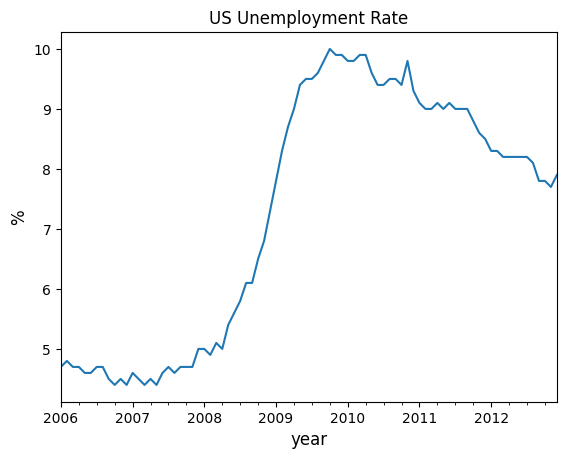

In [11]:
import matplotlib.pyplot as plt
ax = data['2006':'2012'].plot(title='US Unemployment Rate', legend=False)
ax.set_xlabel('year', fontsize=12)
ax.set_ylabel('%', fontsize=12)
plt.show()

The maker of pandas has also authored a library called pandas_datareader that gives access to many data sources straight from Jupyter notebook.
Note that some sources require an access key, but others (e.g., FRED, OECD, EUROSTAT and the World Bank) are free to use.

Let's see an example from the World Bank. The World Bank collects and organizes data on a huge range of indicators.

For example, here’s some data on government debt as a ratio to GDP.

The next code example fetches the data for you and plots time series for the US and Australia

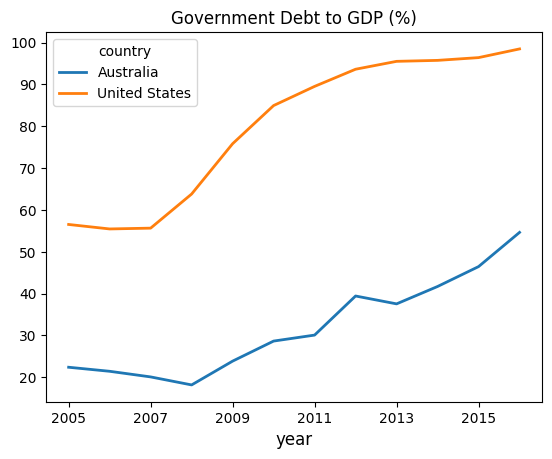

In [12]:
!python -m pip install pandas_datareader --user
from pandas_datareader import wb

govt_debt = wb.download(indicator='GC.DOD.TOTL.GD.ZS', country=['US', 'AU'], start=2005, end=2016).stack().unstack(0)
ind = govt_debt.index.droplevel(-1)
govt_debt.index = ind
ax = govt_debt.plot(lw=2)
ax.set_xlabel('year', fontsize=12)
plt.title("Government Debt to GDP (%)")
plt.show()

## *Exercise 3*
With these imports:

In [13]:
!python -m pip install yfinance --user
import pandas as pd
import datetime as dt
import yfinance as yf
import matplotlib.pyplot as plt

 Write a program to calculate the percentage price change over 2019 for the following shares:

In [46]:
ticker_list = {'INTC': 'Intel',
               'MSFT': 'Microsoft',
               'IBM': 'IBM',
               'BHP': 'BHP',
               'TM': 'Toyota',
               'AAPL': 'Apple',
               'AMZN': 'Amazon',
               'BA': 'Boeing',
               'QCOM': 'Qualcomm',
               'KO': 'Coca-Cola',
               'GOOG': 'Google'}

               
Here’s the first part of the program.

In [47]:
def read_data(ticker_list,
          start=dt.datetime(2019, 1, 2),
          end=dt.datetime(2019, 12, 31)):
    """
    This function reads in closing price data from Yahoo
    for each tick in the ticker_list.
    """
    ticker = pd.DataFrame()

    for tick in ticker_list:
        stock = yf.Ticker(tick)
        prices = stock.history(start=start, end=end)
        closing_prices = prices['Close']
        ticker[tick] = closing_prices

    return ticker

ticker = read_data(ticker_list)

print(ticker['INTC'][0])

41.06069564819336


C:\Users\sofia\AppData\Local\Temp\ipykernel_19072\1044089016.py:20: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print(ticker['INTC'][0])


Complete the program to plot the result as a bar graph like this one:

<img src ="data_lab2/pandas_share_prices.png">

INTC 29.794807881777974
MSFT 58.148889715206465
IBM 20.805428517805762
BHP 25.64178251384365
TM 20.923634405289086
AAPL 87.37340704610888
AMZN 19.995713227192415
BA 3.122365496534919
QCOM 59.75307299688926
KO 21.502855319066857
GOOG 27.756370017431216


C:\Users\sofia\AppData\Local\Temp\ipykernel_19072\2002777659.py:3: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  pct_change = ((ticker[tick][-1] - ticker[tick][0])/ticker[tick][0])*100


<BarContainer object of 11 artists>

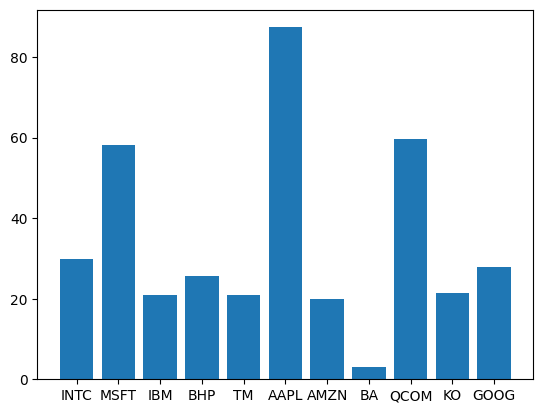

In [49]:
dict = {}
for tick in ticker_list:
    pct_change = ((ticker[tick][-1] - ticker[tick][0])/ticker[tick][0])*100
    print(tick, pct_change)
    dict[tick] = pct_change 
plt.bar(dict.keys(), dict.values())

## *End of exercise*

## *Exercise 4*

Using the method **read_data** introduced in Exercise 3, write a program to obtain year-on-year percentage change for the following indices:

In [66]:
indices_list = {'^GSPC': 'S&P 500',
               '^IXIC': 'NASDAQ',
               '^DJI': 'Dow Jones',
               '^N225': 'Nikkei'}

Complete the program to show summary statistics and plot the result as a time series graph like this one:
<img src = "data/pandas_indices_pctchange.png">

## *End of exercise*


# Part II

## 4. Pandas Fundamentals

This section introduces the new user to the key functionality of Pandas that is required to use the software effectively.

For some variety, we will employ some baseball data.

In [18]:
baseball = pd.read_csv("data_lab2/baseball.csv", index_col='id')
baseball.head()

,player,year,stint,team,lg,g,ab,r,h,X2b,...,rbi,sb,cs,bb,so,ibb,hbp,sh,sf,gidp
id,,,,,,,,,,,,,,,,,,,,,
88641,womacto01,2006,2,CHN,NL,19,50,6,14,1,...,2.0,1.0,1.0,4,4.0,0.0,0.0,3.0,0.0,0.0
88643,schilcu01,2006,1,BOS,AL,31,2,0,1,0,...,0.0,0.0,0.0,0,1.0,0.0,0.0,0.0,0.0,0.0
88645,myersmi01,2006,1,NYA,AL,62,0,0,0,0,...,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0
88649,helliri01,2006,1,MIL,NL,20,3,0,0,0,...,0.0,0.0,0.0,0,2.0,0.0,0.0,0.0,0.0,0.0
88650,johnsra05,2006,1,NYA,AL,33,6,0,1,0,...,0.0,0.0,0.0,0,4.0,0.0,0.0,0.0,0.0,0.0


Notice that we specified the `id` column as the index, since it appears to be a unique identifier. We could try to create a unique index ourselves by combining `player` and `year`:

In [68]:
player_id = baseball.player + baseball.year.astype(str)
baseball_newind = baseball.copy()
baseball_newind.index = player_id
baseball_newind.head()

,player,year,stint,team,lg,g,ab,r,h,X2b,...,rbi,sb,cs,bb,so,ibb,hbp,sh,sf,gidp
womacto012006,womacto01,2006,2,CHN,NL,19,50,6,14,1,...,2.0,1.0,1.0,4,4.0,0.0,0.0,3.0,0.0,0.0
schilcu012006,schilcu01,2006,1,BOS,AL,31,2,0,1,0,...,0.0,0.0,0.0,0,1.0,0.0,0.0,0.0,0.0,0.0
myersmi012006,myersmi01,2006,1,NYA,AL,62,0,0,0,0,...,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0
helliri012006,helliri01,2006,1,MIL,NL,20,3,0,0,0,...,0.0,0.0,0.0,0,2.0,0.0,0.0,0.0,0.0,0.0
johnsra052006,johnsra05,2006,1,NYA,AL,33,6,0,1,0,...,0.0,0.0,0.0,0,4.0,0.0,0.0,0.0,0.0,0.0


This looks okay, but let's check:

In [69]:
baseball_newind.index.is_unique

False

So, indices need not be unique. Our choice is not unique because some players change teams within years.

In [70]:
pd.Series(baseball_newind.index).value_counts()

gomezch022007    2
francju012007    2
wellsda012007    2
loftoke012007    2
sweenma012007    2
                ..
stairma012007    1
stantmi022007    1
stinnke012007    1
suppaje012007    1
alomasa022007    1
Length: 88, dtype: int64

The most important consequence of a non-unique index is that indexing by label will return multiple values for some labels:

In [71]:
baseball_newind.loc['wickmbo012007']

,player,year,stint,team,lg,g,ab,r,h,X2b,...,rbi,sb,cs,bb,so,ibb,hbp,sh,sf,gidp
wickmbo012007,wickmbo01,2007,2,ARI,NL,8,0,0,0,0,...,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0
wickmbo012007,wickmbo01,2007,1,ATL,NL,47,0,0,0,0,...,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0


We will learn more about indexing below.

We can create a truly unique index by combining `player`, `team` and `year`:

In [72]:
player_unique = baseball.player + baseball.team + baseball.year.astype(str)
baseball_newind = baseball.copy()
baseball_newind.index = player_unique
baseball_newind.head()

,player,year,stint,team,lg,g,ab,r,h,X2b,...,rbi,sb,cs,bb,so,ibb,hbp,sh,sf,gidp
womacto01CHN2006,womacto01,2006,2,CHN,NL,19,50,6,14,1,...,2.0,1.0,1.0,4,4.0,0.0,0.0,3.0,0.0,0.0
schilcu01BOS2006,schilcu01,2006,1,BOS,AL,31,2,0,1,0,...,0.0,0.0,0.0,0,1.0,0.0,0.0,0.0,0.0,0.0
myersmi01NYA2006,myersmi01,2006,1,NYA,AL,62,0,0,0,0,...,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0
helliri01MIL2006,helliri01,2006,1,MIL,NL,20,3,0,0,0,...,0.0,0.0,0.0,0,2.0,0.0,0.0,0.0,0.0,0.0
johnsra05NYA2006,johnsra05,2006,1,NYA,AL,33,6,0,1,0,...,0.0,0.0,0.0,0,4.0,0.0,0.0,0.0,0.0,0.0


In [73]:
baseball_newind.index.is_unique

True

We can create meaningful indices more easily using a hierarchical index; for now, we will stick with the numeric `id` field as our index.

### Manipulating indices

**Reindexing** allows users to manipulate the data labels in a DataFrame. It forces a DataFrame to conform to the new index, and optionally, fill in missing data if requested.

A simple use of `reindex` is to alter the order of the rows:

In [74]:
baseball.reindex(baseball.index[::-1]).head()

,player,year,stint,team,lg,g,ab,r,h,X2b,...,rbi,sb,cs,bb,so,ibb,hbp,sh,sf,gidp
id,,,,,,,,,,,,,,,,,,,,,
89534,alomasa02,2007,1,NYN,NL,8,22,1,3,1,...,0.0,0.0,0.0,0,3.0,0.0,0.0,0.0,0.0,0.0
89533,aloumo01,2007,1,NYN,NL,87,328,51,112,19,...,49.0,3.0,0.0,27,30.0,5.0,2.0,0.0,3.0,13.0
89530,ausmubr01,2007,1,HOU,NL,117,349,38,82,16,...,25.0,6.0,1.0,37,74.0,3.0,6.0,4.0,1.0,11.0
89526,benitar01,2007,1,SFN,NL,19,0,0,0,0,...,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0
89525,benitar01,2007,2,FLO,NL,34,0,0,0,0,...,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0


Notice that the `id` index is not sequential. Say we wanted to populate the table with every `id` value. We could specify and index that is a sequence from the first to the last `id` numbers in the database, and Pandas would fill in the missing data with `NaN` values:

In [75]:
id_range = range(baseball.index.values.min(), baseball.index.values.max())
baseball.reindex(id_range).head()

,player,year,stint,team,lg,g,ab,r,h,X2b,...,rbi,sb,cs,bb,so,ibb,hbp,sh,sf,gidp
id,,,,,,,,,,,,,,,,,,,,,
88641,womacto01,2006.0,2.0,CHN,NL,19.0,50.0,6.0,14.0,1.0,...,2.0,1.0,1.0,4.0,4.0,0.0,0.0,3.0,0.0,0.0
88642,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
88643,schilcu01,2006.0,1.0,BOS,AL,31.0,2.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
88644,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
88645,myersmi01,2006.0,1.0,NYA,AL,62.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Missing values can be filled as desired, either with selected values, or by rule:

In [76]:
baseball[['player','year']].reindex(id_range, method='ffill').head()

,player,year
id,,
88641,womacto01,2006
88642,womacto01,2006
88643,schilcu01,2006
88644,schilcu01,2006
88645,myersmi01,2006


In [77]:
baseball.reindex(id_range, fill_value='mr.nobody', columns=['player']).head()

,player
id,
88641,womacto01
88642,mr.nobody
88643,schilcu01
88644,mr.nobody
88645,myersmi01


Keep in mind that `reindex` does not work if we pass a non-unique index series.

We can remove rows or columns via the `drop` method:

In [78]:
baseball.shape

(100, 22)

In [79]:
baseball.drop([89525, 89526])

,player,year,stint,team,lg,g,ab,r,h,X2b,...,rbi,sb,cs,bb,so,ibb,hbp,sh,sf,gidp
id,,,,,,,,,,,,,,,,,,,,,
88641,womacto01,2006,2,CHN,NL,19,50,6,14,1,...,2.0,1.0,1.0,4,4.0,0.0,0.0,3.0,0.0,0.0
88643,schilcu01,2006,1,BOS,AL,31,2,0,1,0,...,0.0,0.0,0.0,0,1.0,0.0,0.0,0.0,0.0,0.0
88645,myersmi01,2006,1,NYA,AL,62,0,0,0,0,...,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0
88649,helliri01,2006,1,MIL,NL,20,3,0,0,0,...,0.0,0.0,0.0,0,2.0,0.0,0.0,0.0,0.0,0.0
88650,johnsra05,2006,1,NYA,AL,33,6,0,1,0,...,0.0,0.0,0.0,0,4.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
89521,bondsba01,2007,1,SFN,NL,126,340,75,94,14,...,66.0,5.0,0.0,132,54.0,43.0,3.0,0.0,2.0,13.0
89523,biggicr01,2007,1,HOU,NL,141,517,68,130,31,...,50.0,4.0,3.0,23,112.0,0.0,3.0,7.0,5.0,5.0
89530,ausmubr01,2007,1,HOU,NL,117,349,38,82,16,...,25.0,6.0,1.0,37,74.0,3.0,6.0,4.0,1.0,11.0


In [80]:
baseball.drop(['ibb','hbp'], axis=1)

,player,year,stint,team,lg,g,ab,r,h,X2b,X3b,hr,rbi,sb,cs,bb,so,sh,sf,gidp
id,,,,,,,,,,,,,,,,,,,,
88641,womacto01,2006,2,CHN,NL,19,50,6,14,1,0,1,2.0,1.0,1.0,4,4.0,3.0,0.0,0.0
88643,schilcu01,2006,1,BOS,AL,31,2,0,1,0,0,0,0.0,0.0,0.0,0,1.0,0.0,0.0,0.0
88645,myersmi01,2006,1,NYA,AL,62,0,0,0,0,0,0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0
88649,helliri01,2006,1,MIL,NL,20,3,0,0,0,0,0,0.0,0.0,0.0,0,2.0,0.0,0.0,0.0
88650,johnsra05,2006,1,NYA,AL,33,6,0,1,0,0,0,0.0,0.0,0.0,0,4.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
89525,benitar01,2007,2,FLO,NL,34,0,0,0,0,0,0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0
89526,benitar01,2007,1,SFN,NL,19,0,0,0,0,0,0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0
89530,ausmubr01,2007,1,HOU,NL,117,349,38,82,16,3,3,25.0,6.0,1.0,37,74.0,4.0,1.0,11.0


## 5. Indexing and Selection

Indexing works analogously to indexing in NumPy arrays, except we can use the labels in the `Index` object to extract values in addition to arrays of integers.

In [81]:
# Sample Series object
hits = baseball_newind.h
hits

womacto01CHN2006     14
schilcu01BOS2006      1
myersmi01NYA2006      0
helliri01MIL2006      0
johnsra05NYA2006      1
                   ... 
benitar01FLO2007      0
benitar01SFN2007      0
ausmubr01HOU2007     82
aloumo01NYN2007     112
alomasa02NYN2007      3
Name: h, Length: 100, dtype: int64

In [82]:
# Numpy-style indexing
hits[:3]

womacto01CHN2006    14
schilcu01BOS2006     1
myersmi01NYA2006     0
Name: h, dtype: int64

In [83]:
# Indexing by label
hits[['womacto01CHN2006','schilcu01BOS2006']]

womacto01CHN2006    14
schilcu01BOS2006     1
Name: h, dtype: int64

We can also slice with data labels, since they have an intrinsic order within the Index:

In [84]:
hits['womacto01CHN2006':'gonzalu01ARI2006']

womacto01CHN2006     14
schilcu01BOS2006      1
myersmi01NYA2006      0
helliri01MIL2006      0
johnsra05NYA2006      1
finlest01SFN2006    105
gonzalu01ARI2006    159
Name: h, dtype: int64

In [85]:
hits['womacto01CHN2006':'gonzalu01ARI2006'] = 5
hits

C:\Users\Nik_K\AppData\Local\Temp/ipykernel_24740/2406061206.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  hits['womacto01CHN2006':'gonzalu01ARI2006'] = 5


womacto01CHN2006      5
schilcu01BOS2006      5
myersmi01NYA2006      5
helliri01MIL2006      5
johnsra05NYA2006      5
                   ... 
benitar01FLO2007      0
benitar01SFN2007      0
ausmubr01HOU2007     82
aloumo01NYN2007     112
alomasa02NYN2007      3
Name: h, Length: 100, dtype: int64

In a `DataFrame` we can slice along either or both axes:

In [86]:
baseball_newind[['h','ab']]

,h,ab
womacto01CHN2006,5,50
schilcu01BOS2006,5,2
myersmi01NYA2006,5,0
helliri01MIL2006,5,3
johnsra05NYA2006,5,6
...,...,...
benitar01FLO2007,0,0
benitar01SFN2007,0,0
ausmubr01HOU2007,82,349
aloumo01NYN2007,112,328


In [87]:
baseball_newind[baseball_newind.ab>500]

,player,year,stint,team,lg,g,ab,r,h,X2b,...,rbi,sb,cs,bb,so,ibb,hbp,sh,sf,gidp
gonzalu01ARI2006,gonzalu01,2006,1,ARI,NL,153,586,93,5,52,...,73.0,0.0,1.0,69,58.0,10.0,7.0,0.0,6.0,14.0
vizquom01SFN2007,vizquom01,2007,1,SFN,NL,145,513,54,126,18,...,51.0,14.0,6.0,44,48.0,6.0,1.0,14.0,3.0,14.0
thomafr04TOR2007,thomafr04,2007,1,TOR,AL,155,531,63,147,30,...,95.0,0.0,0.0,81,94.0,3.0,7.0,0.0,5.0,14.0
rodriiv01DET2007,rodriiv01,2007,1,DET,AL,129,502,50,141,31,...,63.0,2.0,2.0,9,96.0,1.0,1.0,1.0,2.0,16.0
griffke02CIN2007,griffke02,2007,1,CIN,NL,144,528,78,146,24,...,93.0,6.0,1.0,85,99.0,14.0,1.0,0.0,9.0,14.0
delgaca01NYN2007,delgaca01,2007,1,NYN,NL,139,538,71,139,30,...,87.0,4.0,0.0,52,118.0,8.0,11.0,0.0,6.0,12.0
biggicr01HOU2007,biggicr01,2007,1,HOU,NL,141,517,68,130,31,...,50.0,4.0,3.0,23,112.0,0.0,3.0,7.0,5.0,5.0


The indexing field `loc` allows us to select subsets of rows and columns in an intuitive way:

In [88]:
baseball_newind.loc['gonzalu01ARI2006', ['h','X2b', 'X3b', 'hr']]

h       5
X2b    52
X3b     2
hr     15
Name: gonzalu01ARI2006, dtype: object

In [89]:
baseball_newind.loc[['gonzalu01ARI2006','finlest01SFN2006']]

,player,year,stint,team,lg,g,ab,r,h,X2b,...,rbi,sb,cs,bb,so,ibb,hbp,sh,sf,gidp
gonzalu01ARI2006,gonzalu01,2006,1,ARI,NL,153,586,93,5,52,...,73.0,0.0,1.0,69,58.0,10.0,7.0,0.0,6.0,14.0
finlest01SFN2006,finlest01,2006,1,SFN,NL,139,426,66,5,21,...,40.0,7.0,0.0,46,55.0,2.0,2.0,3.0,4.0,6.0


In [90]:
baseball_newind.loc[:'myersmi01NYA2006', 'hr']

womacto01CHN2006    1
schilcu01BOS2006    0
myersmi01NYA2006    0
Name: hr, dtype: int64

Similarly, the cross-section method `xs` (not a field) extracts a single column or row *by label* and returns it as a `Series`:

In [91]:
baseball_newind.xs('myersmi01NYA2006')

player    myersmi01
year           2006
stint             1
team            NYA
lg               AL
g                62
ab                0
r                 0
h                 5
X2b               0
X3b               0
hr                0
rbi             0.0
sb              0.0
cs              0.0
bb                0
so              0.0
ibb             0.0
hbp             0.0
sh              0.0
sf              0.0
gidp            0.0
Name: myersmi01NYA2006, dtype: object

## 6. Operations

`DataFrame` and `Series` objects allow for several operations to take place either on a single object, or between two or more objects.

For example, we can perform arithmetic on the elements of two objects, such as combining baseball statistics across years:

In [92]:
hr2006 = baseball[baseball.year==2006].xs('hr', axis=1)
hr2006.index = baseball.player[baseball.year==2006]

hr2007 = baseball[baseball.year==2007].xs('hr', axis=1)
hr2007.index = baseball.player[baseball.year==2007]

In [93]:
hr2006 = pd.Series(baseball.hr[baseball.year==2006].values, index=baseball.player[baseball.year==2006])
hr2007 = pd.Series(baseball.hr[baseball.year==2007].values, index=baseball.player[baseball.year==2007])

In [94]:
hr_total = hr2006 + hr2007
hr_total

player
alomasa02   NaN
aloumo01    NaN
ausmubr01   NaN
benitar01   NaN
benitar01   NaN
             ..
wickmbo01   NaN
williwo02   NaN
witasja01   NaN
womacto01   NaN
zaungr01    NaN
Length: 94, dtype: float64

Pandas' data alignment places `NaN` values for labels that do not overlap in the two Series. In fact, there are only 6 players that occur in both years.

In [95]:
hr_total[hr_total.notnull()]

player
finlest01     7.0
gonzalu01    30.0
johnsra05     0.0
myersmi01     0.0
schilcu01     0.0
seleaa01      0.0
dtype: float64

While we do want the operation to honor the data labels in this way, we probably do not want the missing values to be filled with `NaN`. We can use the `add` method to calculate player home run totals by using the `fill_value` argument to insert a zero for home runs where labels do not overlap:

In [96]:
hr2007.add(hr2006, fill_value=0)

player
alomasa02     0.0
aloumo01     13.0
ausmubr01     3.0
benitar01     0.0
benitar01     0.0
             ... 
wickmbo01     0.0
williwo02     1.0
witasja01     0.0
womacto01     1.0
zaungr01     10.0
Length: 94, dtype: float64

Operations can also be **broadcast** between rows or columns.

For example, if we subtract the maximum number of home runs hit from the `hr` column, we get how many fewer than the maximum were hit by each player:

In [97]:
baseball.hr - baseball.hr.max()

id
88641   -34
88643   -35
88645   -35
88649   -35
88650   -35
         ..
89525   -35
89526   -35
89530   -32
89533   -22
89534   -35
Name: hr, Length: 100, dtype: int64

Or, looking at things row-wise, we can see how a particular player compares with the rest of the group with respect to important statistics

In [98]:
baseball.loc[89521]["player"]

'bondsba01'

In [99]:
stats = baseball[['h','X2b', 'X3b', 'hr']]
diff = stats - stats.xs(89521)
diff[:10]

,h,X2b,X3b,hr
id,,,,
88641,-80,-13,0,-27
88643,-93,-14,0,-28
88645,-94,-14,0,-28
88649,-94,-14,0,-28
88650,-93,-14,0,-28
88652,11,7,12,-22
88653,65,38,2,-13
88662,-89,-13,0,-28
89177,-84,-11,0,-28


We can also apply functions to each column or row of a `DataFrame`

In [100]:
stats.apply(np.median)

h      8.0
X2b    1.0
X3b    0.0
hr     0.0
dtype: float64

In [101]:
stat_range = lambda x: x.max() - x.min()
stats.apply(stat_range)

h      159
X2b     52
X3b     12
hr      35
dtype: int64

Lets use apply to calculate a meaningful baseball statistics, slugging percentage:

$$SLG = \frac{1B + (2 \times 2B) + (3 \times 3B) + (4 \times HR)}{AB}$$

And just for fun, we will format the resulting estimate.

In [102]:
slg = lambda x: (x['h']-x['X2b']-x['X3b']-x['hr'] + 2*x['X2b'] + 3*x['X3b'] + 4*x['hr'])/(x['ab']+1e-6)
baseball.apply(slg, axis=1).apply(lambda x: '%.3f' % x)

id
88641    0.360
88643    0.500
88645    0.000
88649    0.000
88650    0.167
         ...  
89525    0.000
89526    0.000
89530    0.324
89533    0.524
89534    0.182
Length: 100, dtype: object

## 7. Sorting and Ranking

Pandas objects include methods for re-ordering data.

In [103]:
baseball_newind.sort_index().head()

,player,year,stint,team,lg,g,ab,r,h,X2b,...,rbi,sb,cs,bb,so,ibb,hbp,sh,sf,gidp
alomasa02NYN2007,alomasa02,2007,1,NYN,NL,8,22,1,3,1,...,0.0,0.0,0.0,0,3.0,0.0,0.0,0.0,0.0,0.0
aloumo01NYN2007,aloumo01,2007,1,NYN,NL,87,328,51,112,19,...,49.0,3.0,0.0,27,30.0,5.0,2.0,0.0,3.0,13.0
ausmubr01HOU2007,ausmubr01,2007,1,HOU,NL,117,349,38,82,16,...,25.0,6.0,1.0,37,74.0,3.0,6.0,4.0,1.0,11.0
benitar01FLO2007,benitar01,2007,2,FLO,NL,34,0,0,0,0,...,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0
benitar01SFN2007,benitar01,2007,1,SFN,NL,19,0,0,0,0,...,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0


In [104]:
baseball_newind.sort_index(ascending=False).head()

,player,year,stint,team,lg,g,ab,r,h,X2b,...,rbi,sb,cs,bb,so,ibb,hbp,sh,sf,gidp
zaungr01TOR2007,zaungr01,2007,1,TOR,AL,110,331,43,80,24,...,52.0,0.0,0.0,51,55.0,8.0,2.0,1.0,6.0,9.0
womacto01CHN2006,womacto01,2006,2,CHN,NL,19,50,6,5,1,...,2.0,1.0,1.0,4,4.0,0.0,0.0,3.0,0.0,0.0
witasja01TBA2007,witasja01,2007,1,TBA,AL,3,0,0,0,0,...,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0
williwo02HOU2007,williwo02,2007,1,HOU,NL,33,59,3,6,0,...,2.0,0.0,0.0,0,25.0,0.0,0.0,5.0,0.0,1.0
wickmbo01ATL2007,wickmbo01,2007,1,ATL,NL,47,0,0,0,0,...,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0


In [105]:
baseball_newind.sort_index(axis=1).head()

,X2b,X3b,ab,bb,cs,g,gidp,h,hbp,hr,...,player,r,rbi,sb,sf,sh,so,stint,team,year
womacto01CHN2006,1,0,50,4,1.0,19,0.0,5,0.0,1,...,womacto01,6,2.0,1.0,0.0,3.0,4.0,2,CHN,2006
schilcu01BOS2006,0,0,2,0,0.0,31,0.0,5,0.0,0,...,schilcu01,0,0.0,0.0,0.0,0.0,1.0,1,BOS,2006
myersmi01NYA2006,0,0,0,0,0.0,62,0.0,5,0.0,0,...,myersmi01,0,0.0,0.0,0.0,0.0,0.0,1,NYA,2006
helliri01MIL2006,0,0,3,0,0.0,20,0.0,5,0.0,0,...,helliri01,0,0.0,0.0,0.0,0.0,2.0,1,MIL,2006
johnsra05NYA2006,0,0,6,0,0.0,33,0.0,5,0.0,0,...,johnsra05,0,0.0,0.0,0.0,0.0,4.0,1,NYA,2006


We can also use `sort_values` to sort a `Series` by value, rather than by label.

In [106]:
baseball.hr.sort_values(ascending=False)

id
89360    35
89462    30
89521    28
89361    26
89378    25
         ..
89442     0
89445     0
89450     0
89451     0
89534     0
Name: hr, Length: 100, dtype: int64

For a `DataFrame`, we can sort according to the values of one or more columns using the `by` argument of `sort_values`:

In [107]:
baseball[['player','sb','cs']].sort_values(ascending=[False,True], by=['sb', 'cs']).head(10)

,player,sb,cs
id,,,
89378,sheffga01,22.0,5.0
89430,loftoke01,21.0,4.0
89347,vizquom01,14.0,6.0
89463,greensh01,11.0,1.0
88652,finlest01,7.0,0.0
89462,griffke02,6.0,1.0
89530,ausmubr01,6.0,1.0
89466,gonzalu01,6.0,2.0
89521,bondsba01,5.0,0.0


**Ranking** does not re-arrange data, but instead returns an index that ranks each value relative to others in the Series.

In [108]:
baseball.hr.rank()

id
88641    62.5
88643    29.0
88645    29.0
88649    29.0
88650    29.0
         ... 
89525    29.0
89526    29.0
89530    71.5
89533    88.0
89534    29.0
Name: hr, Length: 100, dtype: float64

Ties are assigned the mean value of the tied ranks, which may result in decimal values.

In [109]:
pd.Series([100,100]).rank()

0    1.5
1    1.5
dtype: float64

Alternatively, you can break ties via one of several methods, such as by the order in which they occur in the dataset:

In [110]:
baseball.hr.rank(method='first')

id
88641    58.0
88643     1.0
88645     2.0
88649     3.0
88650     4.0
         ... 
89525    55.0
89526    56.0
89530    72.0
89533    88.0
89534    57.0
Name: hr, Length: 100, dtype: float64

Calling the `DataFrame`'s `rank` method results in the ranks of all columns:

In [111]:
baseball.rank(ascending=False).head()

,player,year,stint,team,lg,g,ab,r,h,X2b,...,rbi,sb,cs,bb,so,ibb,hbp,sh,sf,gidp
id,,,,,,,,,,,,,,,,,,,,,
88641,2.0,96.5,7.0,82.0,31.5,70.0,47.5,40.5,39.0,50.5,...,51.0,24.5,17.5,44.5,59.0,66.0,65.5,16.0,70.0,76.5
88643,37.5,96.5,57.0,88.0,81.5,55.5,73.0,81.0,63.5,78.0,...,78.5,63.5,62.5,79.0,73.0,66.0,65.5,67.5,70.0,76.5
88645,47.5,96.5,57.0,40.5,81.5,36.0,91.0,81.0,84.5,78.0,...,78.5,63.5,62.5,79.0,89.0,66.0,65.5,67.5,70.0,76.5
88649,66.0,96.5,57.0,47.0,31.5,67.5,69.0,81.0,84.5,78.0,...,78.5,63.5,62.5,79.0,67.0,66.0,65.5,67.5,70.0,76.5
88650,61.5,96.5,57.0,40.5,81.5,51.0,64.5,81.0,63.5,78.0,...,78.5,63.5,62.5,79.0,59.0,66.0,65.5,67.5,70.0,76.5


In [112]:
baseball[['r','h','hr']].rank(ascending=False).head()

,r,h,hr
id,,,
88641,40.5,39.0,38.5
88643,81.0,63.5,72.0
88645,81.0,84.5,72.0
88649,81.0,84.5,72.0
88650,81.0,63.5,72.0


## 8. Hierarchical indexing

In the baseball example, I was forced to combine 3 fields to obtain a unique index that was not simply an integer value. A more elegant way to have done this would be to create a hierarchical index from the three fields.

In [113]:
baseball_h = baseball.set_index(['year', 'team', 'player'])
baseball_h.head(10)

stint  lg    g   ab   r    h  X2b  X3b  hr   rbi   sb  \
year team player                                                             
2006 CHN  womacto01      2  NL   19   50   6   14    1    0   1   2.0  1.0   
     BOS  schilcu01      1  AL   31    2   0    1    0    0   0   0.0  0.0   
     NYA  myersmi01      1  AL   62    0   0    0    0    0   0   0.0  0.0   
     MIL  helliri01      1  NL   20    3   0    0    0    0   0   0.0  0.0   
     NYA  johnsra05      1  AL   33    6   0    1    0    0   0   0.0  0.0   
     SFN  finlest01      1  NL  139  426  66  105   21   12   6  40.0  7.0   
     ARI  gonzalu01      1  NL  153  586  93  159   52    2  15  73.0  0.0   
     LAN  seleaa01       1  NL   28   26   2    5    1    0   0   0.0  0.0   
2007 ATL  francju01      2  NL   15   40   1   10    3    0   0   8.0  0.0   
     NYN  francju01      1  NL   40   50   7   10    0    0   1   8.0  2.0   

                      cs  bb    so   ibb  hbp   sh   sf  gidp  
year team player                                               
2006 CHN  womacto01  1.0   4   4.0   0.0  0.0  3.0  0.0   0.0  
     BOS  schilcu01  0.0   0   1.0   0.0  0.0  0.0  0.0   0.0  
     NYA  myersmi01  0.0   0   0.0   0.0  0.0  0.0  0.0   0.0  
     MIL  helliri01  0.0   0   2.0   0.0  0.0  0.0  0.0   0.0  
     NYA  johnsra05  0.0   0   4.0   0.0  0.0  0.0  0.0   0.0  
     SFN  finlest01  0.0  46  55.0   2.0  2.0  3.0  4.0   6.0  
     ARI  gonzalu01  1.0  69  58.0  10.0  7.0  0.0  6.0  14.0  
     LAN  seleaa01   0.0   1   7.0   0.0  0.0  6.0  0.0   1.0  
2007 ATL  francju01  0.0   4  10.0   1.0  0.0  0.0  1.0   1.0  
     NYN  francju01  1.0  10  13.0   0.0  0.0  0.0  1.0   1.0

This index is a `MultiIndex` object that consists of a sequence of tuples, the elements of which is some combination of the three columns used to create the index. Where there are multiple repeated values, Pandas does not print the repeats, making it easy to identify groups of values.

In [114]:
baseball_h.index[:10]

MultiIndex([(2006, 'CHN', 'womacto01'),
            (2006, 'BOS', 'schilcu01'),
            (2006, 'NYA', 'myersmi01'),
            (2006, 'MIL', 'helliri01'),
            (2006, 'NYA', 'johnsra05'),
            (2006, 'SFN', 'finlest01'),
            (2006, 'ARI', 'gonzalu01'),
            (2006, 'LAN',  'seleaa01'),
            (2007, 'ATL', 'francju01'),
            (2007, 'NYN', 'francju01')],
           names=['year', 'team', 'player'])

In [115]:
baseball_h.index.is_unique

True

In [116]:
baseball_h.loc[(2007, 'ATL', 'francju01')]

stint       2
lg         NL
g          15
ab         40
r           1
h          10
X2b         3
X3b         0
hr          0
rbi       8.0
sb        0.0
cs        0.0
bb          4
so       10.0
ibb       1.0
hbp       0.0
sh        0.0
sf        1.0
gidp      1.0
Name: (2007, ATL, francju01), dtype: object

Recall earlier we imported some microbiome data using two index columns. This created a 2-level hierarchical index:

In [117]:
mb = pd.read_csv("data/microbiome.csv", index_col=['Taxon','Patient'])

In [118]:
mb.head(10)

Tissue  Stool
Taxon      Patient               
Firmicutes 1           632    305
           2           136   4182
           3          1174    703
           4           408   3946
           5           831   8605
           6           693     50
           7           718    717
           8           173     33
           9           228     80
           10          162   3196

In [119]:
mb.index

MultiIndex([(    'Firmicutes',  1),
            (    'Firmicutes',  2),
            (    'Firmicutes',  3),
            (    'Firmicutes',  4),
            (    'Firmicutes',  5),
            (    'Firmicutes',  6),
            (    'Firmicutes',  7),
            (    'Firmicutes',  8),
            (    'Firmicutes',  9),
            (    'Firmicutes', 10),
            (    'Firmicutes', 11),
            (    'Firmicutes', 12),
            (    'Firmicutes', 13),
            (    'Firmicutes', 14),
            (    'Firmicutes', 15),
            ('Proteobacteria',  1),
            ('Proteobacteria',  2),
            ('Proteobacteria',  3),
            ('Proteobacteria',  4),
            ('Proteobacteria',  5),
            ('Proteobacteria',  6),
            ('Proteobacteria',  7),
            ('Proteobacteria',  8),
            ('Proteobacteria',  9),
            ('Proteobacteria', 10),
            ('Proteobacteria', 11),
            ('Proteobacteria', 12),
            ('Proteobacteria

With a hierachical index, we can select subsets of the data based on a *partial* index:

In [120]:
mb.loc['Proteobacteria']

,Tissue,Stool
Patient,,
1,1638,3886
2,2469,1821
3,839,661
4,4414,18
5,12044,83
6,2310,12
7,3053,547
8,395,2174
9,2651,767


Hierarchical indices can be created on either or both axes. Here is a trivial example:

In [121]:
frame = pd.DataFrame(np.arange(12).reshape(( 4, 3)), 
                  index =[['a', 'a', 'b', 'b'], [1, 2, 1, 2]], 
                  columns =[['Ohio', 'Ohio', 'Colorado'], ['Green', 'Red', 'Green']])

frame

Ohio     Colorado
    Green Red    Green
a 1     0   1        2
  2     3   4        5
b 1     6   7        8
  2     9  10       11

If you want to get fancy, both the row and column indices themselves can be given names:

In [122]:
frame.index.names = ['key1', 'key2']
frame.columns.names = ['state', 'color']
frame

state      Ohio     Colorado
color     Green Red    Green
key1 key2                   
a    1        0   1        2
     2        3   4        5
b    1        6   7        8
     2        9  10       11

With this, we can do all sorts of custom indexing:

In [123]:
frame.loc['a']['Ohio']

color,Green,Red
key2,,
1,0,1
2,3,4


In [124]:
frame.loc['b', 2]['Colorado']

color
Green    11
Name: (b, 2), dtype: int32

Additionally, the order of the set of indices in a hierarchical `MultiIndex` can be changed by swapping them pairwise:

In [125]:
mb.swaplevel('Patient', 'Taxon').head()

,,Tissue,Stool
Patient,Taxon,,
1,Firmicutes,632,305
2,Firmicutes,136,4182
3,Firmicutes,1174,703
4,Firmicutes,408,3946
5,Firmicutes,831,8605


Data can also be sorted by any index level, using `sort_index`:

In [126]:
mb.sort_index(level='Patient', ascending=False).head()

,,Tissue,Stool
Taxon,Patient,,
Proteobacteria,15,1307,53
Other,15,305,32
Firmicutes,15,281,2377
Bacteroidetes,15,102,33
Actinobacteria,15,310,204


## 9. Missing data

The occurence of missing data is so prevalent that it pays to use tools like Pandas, which seamlessly integrates missing data handling so that it can be dealt with easily, and in the manner required by the analysis at hand.

Missing data are represented in `Series` and `DataFrame` objects by the `NaN` floating point value. However, `None` is also treated as missing, since it is commonly used as such in other contexts (*e.g.* NumPy).

In [127]:
foo = pd.Series([np.nan, -3, None, 'foobar'])
foo

0       NaN
1        -3
2      None
3    foobar
dtype: object

In [128]:
foo.isnull()

0     True
1    False
2     True
3    False
dtype: bool

Missing values may be dropped or indexed out:

In [129]:
bacteria2

phylum
Firmicutes           NaN
Proteobacteria     632.0
Actinobacteria    1638.0
Bacteroidetes      569.0
dtype: float64

In [130]:
bacteria2.dropna()

phylum
Proteobacteria     632.0
Actinobacteria    1638.0
Bacteroidetes      569.0
dtype: float64

In [131]:
bacteria2[bacteria2.notnull()]

phylum
Proteobacteria     632.0
Actinobacteria    1638.0
Bacteroidetes      569.0
dtype: float64

By default, `dropna` drops entire rows in which one or more values are missing.

In [132]:
data

,VALUE
DATE,
1948-01-01,3.4
1948-02-01,3.8
1948-03-01,4.0
1948-04-01,3.9
1948-05-01,3.5
...,...
2023-08-01,3.8
2023-09-01,3.8
2023-10-01,3.8


In [133]:
data.dropna()

,VALUE
DATE,
1948-01-01,3.4
1948-02-01,3.8
1948-03-01,4.0
1948-04-01,3.9
1948-05-01,3.5
...,...
2023-08-01,3.8
2023-09-01,3.8
2023-10-01,3.8


This can be overridden by passing the `how='all'` argument, which only drops a row when every field is a missing value.

In [134]:
data.dropna(how='all')

,VALUE
DATE,
1948-01-01,3.4
1948-02-01,3.8
1948-03-01,4.0
1948-04-01,3.9
1948-05-01,3.5
...,...
2023-08-01,3.8
2023-09-01,3.8
2023-10-01,3.8


This can be customized further by specifying how many values need to be present before a row is dropped via the `thresh` argument.

In [135]:
data.loc[7, 'year'] = np.nan
data

,VALUE,year
DATE,,
1948-01-01 00:00:00,3.4,NaN
1948-02-01 00:00:00,3.8,NaN
1948-03-01 00:00:00,4.0,NaN
1948-04-01 00:00:00,3.9,NaN
1948-05-01 00:00:00,3.5,NaN
...,...,...
2023-09-01 00:00:00,3.8,NaN
2023-10-01 00:00:00,3.8,NaN
2023-11-01 00:00:00,3.7,NaN


In [136]:
data.dropna(thresh=4)

,VALUE,year
DATE,,


This is typically used in time series applications, where there are repeated measurements that are incomplete for some subjects.

If we want to drop missing values column-wise instead of row-wise, we use `axis=1`.

In [137]:
data.dropna(axis=1)

""
DATE
1948-01-01 00:00:00
1948-02-01 00:00:00
1948-03-01 00:00:00
1948-04-01 00:00:00
1948-05-01 00:00:00
...
2023-09-01 00:00:00
2023-10-01 00:00:00
2023-11-01 00:00:00


Rather than omitting missing data from an analysis, in some cases it may be suitable to fill the missing value in, either with a default value (such as zero) or a value that is either imputed or carried forward/backward from similar data points. We can do this programmatically in Pandas with the `fillna` argument.

In [138]:
bacteria2.fillna(0)

phylum
Firmicutes           0.0
Proteobacteria     632.0
Actinobacteria    1638.0
Bacteroidetes      569.0
dtype: float64

In [139]:
data.fillna({'year': 2013, 'treatment':2})

,VALUE,year
DATE,,
1948-01-01 00:00:00,3.4,2013.0
1948-02-01 00:00:00,3.8,2013.0
1948-03-01 00:00:00,4.0,2013.0
1948-04-01 00:00:00,3.9,2013.0
1948-05-01 00:00:00,3.5,2013.0
...,...,...
2023-09-01 00:00:00,3.8,2013.0
2023-10-01 00:00:00,3.8,2013.0
2023-11-01 00:00:00,3.7,2013.0


Notice that `fillna` by default returns a new object with the desired filling behavior, rather than changing the `Series` or  `DataFrame` in place (**in general, we like to do this, by the way!**).

In [140]:
data

,VALUE,year
DATE,,
1948-01-01 00:00:00,3.4,NaN
1948-02-01 00:00:00,3.8,NaN
1948-03-01 00:00:00,4.0,NaN
1948-04-01 00:00:00,3.9,NaN
1948-05-01 00:00:00,3.5,NaN
...,...,...
2023-09-01 00:00:00,3.8,NaN
2023-10-01 00:00:00,3.8,NaN
2023-11-01 00:00:00,3.7,NaN


We can alter values in-place using `inplace=True`.

In [141]:
_ = data.year.fillna(2013, inplace=True)
data

,VALUE,year
DATE,,
1948-01-01 00:00:00,3.4,2013.0
1948-02-01 00:00:00,3.8,2013.0
1948-03-01 00:00:00,4.0,2013.0
1948-04-01 00:00:00,3.9,2013.0
1948-05-01 00:00:00,3.5,2013.0
...,...,...
2023-09-01 00:00:00,3.8,2013.0
2023-10-01 00:00:00,3.8,2013.0
2023-11-01 00:00:00,3.7,2013.0


Missing values can also be interpolated, using any one of a variety of methods:

In [142]:
bacteria2.fillna(method='bfill')

phylum
Firmicutes         632.0
Proteobacteria     632.0
Actinobacteria    1638.0
Bacteroidetes      569.0
dtype: float64

In [143]:
bacteria2.fillna(bacteria2.mean())

phylum
Firmicutes         946.333333
Proteobacteria     632.000000
Actinobacteria    1638.000000
Bacteroidetes      569.000000
dtype: float64

## 10. Data summarization

We often wish to summarize data in `Series` or `DataFrame` objects, so that they can more easily be understood or compared with similar data. The NumPy package contains several functions that are useful here, but several summarization or reduction methods are built into Pandas data structures.

In [144]:
baseball.sum()

player    womacto01schilcu01myersmi01helliri01johnsra05f...
year                                                 200692
stint                                                   113
team      CHNBOSNYAMILNYASFNARILANATLNYNTORTBAHOUARIATLM...
lg        NLALALNLALNLNLNLNLNLALALNLNLNLALNLNLNLNLALALNL...
g                                                      5238
ab                                                    13654
r                                                      1869
h                                                      3582
X2b                                                     739
X3b                                                      55
hr                                                      437
rbi                                                  1847.0
sb                                                    138.0
cs                                                     46.0
bb                                                     1549
so                                      

Clearly, `sum` is more meaningful for some columns than others. For methods like `mean` for which application to string variables is not just meaningless, but impossible, these columns are automatically excluded:

In [145]:
baseball.mean(numeric_only=True)

year     2006.92
stint       1.13
g          52.38
ab        136.54
r          18.69
h          35.82
X2b         7.39
X3b         0.55
hr          4.37
rbi        18.47
sb          1.38
cs          0.46
bb         15.49
so         24.08
ibb         1.77
hbp         1.12
sh          1.38
sf          1.20
gidp        3.54
dtype: float64

The important difference between NumPy's functions and Pandas' methods is that the latter have built-in support for handling missing data.

In [146]:
bacteria2

phylum
Firmicutes           NaN
Proteobacteria     632.0
Actinobacteria    1638.0
Bacteroidetes      569.0
dtype: float64

In [147]:
bacteria2.mean()

946.3333333333334

Sometimes we may not want to ignore missing values, and allow the `nan` to propagate.

In [148]:
bacteria2.mean(skipna=False)

nan

Passing `axis=1` will summarize over rows instead of columns, which only makes sense in certain situations.

In [149]:
extra_bases = baseball[['X2b','X3b','hr']].sum(axis=1)
extra_bases.sort_values(ascending=False)

id
88653    69
89439    57
89361    56
89462    55
89396    54
         ..
89460     0
89363     0
89359     0
89384     0
89355     0
Length: 100, dtype: int64

A useful summarization that gives a quick snapshot of multiple statistics for a `Series` or `DataFrame` is `describe`:

In [150]:
baseball.describe()

,year,stint,g,ab,r,h,X2b,X3b,hr,rbi,sb,cs,bb,so,ibb,hbp,sh,sf,gidp
count,100.00000,100.000000,100.000000,100.000000,100.00000,100.000000,100.000000,100.000000,100.000000,100.00000,100.000000,100.000000,100.000000,100.000000,100.000000,100.00000,100.000000,100.000000,100.000000
mean,2006.92000,1.130000,52.380000,136.540000,18.69000,35.820000,7.390000,0.550000,4.370000,18.47000,1.380000,0.460000,15.490000,24.080000,1.770000,1.12000,1.380000,1.200000,3.540000
std,0.27266,0.337998,48.031299,181.936853,27.77496,50.221807,11.117277,1.445124,7.975537,28.34793,3.694878,1.067613,25.812649,32.804496,5.042957,2.23055,2.919042,2.035046,5.201826
min,2006.00000,1.000000,1.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000
25%,2007.00000,1.000000,9.500000,2.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,1.000000,0.000000,0.00000,0.000000,0.000000,0.000000
50%,2007.00000,1.000000,33.000000,40.500000,2.00000,8.000000,1.000000,0.000000,0.000000,2.00000,0.000000,0.000000,1.000000,7.000000,0.000000,0.00000,0.000000,0.000000,1.000000
75%,2007.00000,1.000000,83.250000,243.750000,33.25000,62.750000,11.750000,1.000000,6.000000,27.00000,1.000000,0.000000,19.250000,37.250000,1.250000,1.00000,1.000000,2.000000,6.000000
max,2007.00000,2.000000,155.000000,586.000000,107.00000,159.000000,52.000000,12.000000,35.000000,96.00000,22.000000,6.000000,132.000000,134.000000,43.000000,11.00000,14.000000,9.000000,21.000000


`describe` can detect non-numeric data and sometimes yield useful information about it.

In [151]:
baseball.player.describe()

count           100
unique           82
top       wellsda01
freq              2
Name: player, dtype: object

We can also calculate summary statistics *across* multiple columns, for example, correlation and covariance.

$$cov(x,y) = \sum_i (x_i - \bar{x})(y_i - \bar{y})$$

In [152]:
baseball.hr.cov(baseball.X2b)

69.07646464646454

$$corr(x,y) = \frac{cov(x,y)}{(n-1)s_x s_y} = \frac{\sum_i (x_i - \bar{x})(y_i - \bar{y})}{\sqrt{\sum_i (x_i - \bar{x})^2 \sum_i (y_i - \bar{y})^2}}$$

In [153]:
baseball.hr.corr(baseball.X2b)

0.7790615182539742

In [154]:
baseball.ab.corr(baseball.h)

0.9942174036272377

In [155]:
baseball.corr()

,year,stint,g,ab,r,h,X2b,X3b,hr,rbi,sb,cs,bb,so,ibb,hbp,sh,sf,gidp
year,1.000000,0.004384,-0.050874,-0.001360,-0.023315,0.001151,-0.052917,-0.246099,0.060199,0.042812,0.030480,0.058296,0.005626,0.069610,0.015868,-0.000664,-0.012184,-0.007282,0.052131
stint,0.004384,1.000000,-0.257552,-0.216333,-0.209781,-0.206878,-0.196423,-0.085821,-0.209124,-0.205688,-0.120837,-0.055425,-0.190301,-0.214121,-0.118580,-0.195074,-0.091527,-0.155662,-0.224173
g,-0.050874,-0.257552,1.000000,0.935910,0.910262,0.929292,0.885847,0.518663,0.802014,0.891563,0.492362,0.520923,0.828572,0.866499,0.514423,0.730161,0.079361,0.767543,0.863041
ab,-0.001360,-0.216333,0.935910,1.000000,0.965609,0.994217,0.952249,0.535986,0.843308,0.947911,0.533536,0.577192,0.850803,0.923926,0.506398,0.767210,0.094537,0.840361,0.926632
r,-0.023315,-0.209781,0.910262,0.965609,1.000000,0.970560,0.923508,0.500807,0.890060,0.941483,0.596343,0.576454,0.915010,0.879375,0.588882,0.806523,-0.001273,0.839592,0.894724
h,0.001151,-0.206878,0.929292,0.994217,0.970560,1.000000,0.957275,0.514245,0.855163,0.952320,0.530018,0.571629,0.853384,0.906966,0.513009,0.767449,0.045533,0.839737,0.935525
X2b,-0.052917,-0.196423,0.885847,0.952249,0.923508,0.957275,1.000000,0.493267,0.779062,0.901751,0.413655,0.477487,0.780012,0.862149,0.453301,0.738226,0.005659,0.819361,0.906860
X3b,-0.246099,-0.085821,0.518663,0.535986,0.500807,0.514245,0.493267,1.000000,0.210028,0.369890,0.450421,0.384312,0.350682,0.408800,0.090993,0.217474,0.187012,0.394987,0.411577
hr,0.060199,-0.209124,0.802014,0.843308,0.890060,0.855163,0.779062,0.210028,1.000000,0.948787,0.364346,0.345187,0.916774,0.865929,0.673691,0.767411,-0.145374,0.782038,0.798350
rbi,0.042812,-0.205688,0.891563,0.947911,0.941483,0.952320,0.901751,0.369890,0.948787,1.000000,0.394633,0.435011,0.893945,0.929410,0.582982,0.780899,-0.054670,0.855260,0.906908


If we have a `DataFrame` with a hierarchical index (or indices), summary statistics can be applied with respect to any of the index levels:

In [156]:
mb.head()

Tissue  Stool
Taxon      Patient               
Firmicutes 1           632    305
           2           136   4182
           3          1174    703
           4           408   3946
           5           831   8605

In [157]:
mb.groupby(level='Taxon').sum()

,Tissue,Stool
Taxon,,
Actinobacteria,6736,2263
Bacteroidetes,8995,4656
Firmicutes,10266,30477
Other,2982,519
Proteobacteria,44146,16369


## 11. Writing Data to Files

As well as being able to read several data input formats, Pandas can also export data to a variety of storage formats. We will bring your attention to just a couple of these.

In [158]:
mb.to_csv("mb.csv")

The `to_csv` method writes a `DataFrame` to a comma-separated values (csv) file. You can specify custom delimiters (via `sep` argument), how missing values are written (via `na_rep` argument), whether the index is writen (via `index` argument), whether the header is included (via `header` argument), among other options.

An efficient way of storing data to disk is in binary format. Pandas supports this using Python’s built-in pickle serialization.

In [159]:
baseball.to_pickle("baseball_pickle")

The complement to `to_pickle` is the `read_pickle` function, which restores the pickle to a `DataFrame` or `Series`:

In [160]:
pd.read_pickle("baseball_pickle")

,player,year,stint,team,lg,g,ab,r,h,X2b,...,rbi,sb,cs,bb,so,ibb,hbp,sh,sf,gidp
id,,,,,,,,,,,,,,,,,,,,,
88641,womacto01,2006,2,CHN,NL,19,50,6,14,1,...,2.0,1.0,1.0,4,4.0,0.0,0.0,3.0,0.0,0.0
88643,schilcu01,2006,1,BOS,AL,31,2,0,1,0,...,0.0,0.0,0.0,0,1.0,0.0,0.0,0.0,0.0,0.0
88645,myersmi01,2006,1,NYA,AL,62,0,0,0,0,...,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0
88649,helliri01,2006,1,MIL,NL,20,3,0,0,0,...,0.0,0.0,0.0,0,2.0,0.0,0.0,0.0,0.0,0.0
88650,johnsra05,2006,1,NYA,AL,33,6,0,1,0,...,0.0,0.0,0.0,0,4.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
89525,benitar01,2007,2,FLO,NL,34,0,0,0,0,...,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0
89526,benitar01,2007,1,SFN,NL,19,0,0,0,0,...,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0
89530,ausmubr01,2007,1,HOU,NL,117,349,38,82,16,...,25.0,6.0,1.0,37,74.0,3.0,6.0,4.0,1.0,11.0


It is recommended that binary storage of data via pickle only be used as a temporary storage format, in situations where speed is relevant. This is because there is no guarantee that the pickle format will not change with future versions of Python.

# Part III

## Financial data

### Getting financial data
There are several sources and ways to get financial data. One of them is through [yfinance](https://pypi.org/project/yfinance/)



In [161]:
!pip install yfinance

In [162]:
import datetime as dt
import yfinance as yf

company = 'MSFT'

# Define a start date and End Date
start = dt.datetime(2023,1,1)
end =  dt.datetime(2023,12,31)

# Read Stock Price Data 
data = yf.download(company, start , end)

data.tail(10)

[*********************100%%**********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2023-12-15,366.850006,372.399994,366.279999,370.730011,370.730011,78478200
2023-12-18,369.450012,373.000000,368.679993,372.649994,372.649994,21802900
2023-12-19,371.489990,373.260010,369.839996,373.260010,373.260010,20603700
2023-12-20,375.000000,376.029999,370.529999,370.619995,370.619995,26316700
2023-12-21,372.559998,374.410004,370.040009,373.540009,373.540009,17708000
2023-12-22,373.679993,375.179993,372.709991,374.579987,374.579987,17091100
2023-12-26,375.000000,376.940002,373.500000,374.660004,374.660004,12673100
2023-12-27,373.690002,375.059998,372.809998,374.070007,374.070007,14905400
2023-12-28,375.369995,376.459991,374.160004,375.279999,375.279999,14327000


Another way is through the Ticker module

In [163]:
import yfinance as yf
msft = yf.Ticker("MSFT")
msft.info

{'address1': 'One Microsoft Way',
 'city': 'Redmond',
 'state': 'WA',
 'zip': '98052-6399',
 'country': 'United States',
 'phone': '425 882 8080',
 'website': 'https://www.microsoft.com',
 'industry': 'Software - Infrastructure',
 'industryKey': 'software-infrastructure',
 'industryDisp': 'Software - Infrastructure',
 'sector': 'Technology',
 'sectorKey': 'technology',
 'sectorDisp': 'Technology',
 'longBusinessSummary': 'Microsoft Corporation develops and supports software, services, devices and solutions worldwide. The Productivity and Business Processes segment offers office, exchange, SharePoint, Microsoft Teams, office 365 Security and Compliance, Microsoft viva, and Microsoft 365 copilot; and office consumer services, such as Microsoft 365 consumer subscriptions, Office licensed on-premises, and other office services. This segment also provides LinkedIn; and dynamics business solutions, including Dynamics 365, a set of intelligent, cloud-based applications across ERP, CRM, power 

See the [documentation](https://pypi.org/project/yfinance/) for additional methods that can be exploited.

### Processing financial data

We are now going to read financial data from a .csv file (one of the data files to be downloaded from the moodle page).

In [80]:
ftse = pd.read_csv('data_lab2/FTSE100.csv')

When working with large data sets it is useful to view just the first/last few rows in the dataset. We can use the _head()_ method to retrieve the first rows and/or _tail()_ to do the same with the last ones.

In [81]:
ftse.head()

,Date,Open,High,Low,Close,Volume,Adjusted Close
0,4/1/2000,6930.2,6930.2,6662.9,6662.9,0.0,0
1,5/1/2000,6665.9,6665.9,6500.4,6535.9,0.0,0
2,6/1/2000,6535.9,6547.3,6424.4,6447.2,0.0,0
3,7/1/2000,6477.2,6532.4,6438.8,6504.8,0.0,0
4,10/1/2000,6504.8,6634.2,6504.8,6607.7,0.0,0


In [82]:
ftse.tail()

,Date,Open,High,Low,Close,Volume,Adjusted Close
5217,22/12/2020,NaN,NaN,NaN,NaN,NaN,0
5218,23/12/2020,6453.200195,6497.299805,6431.200195,6495.799805,807695400.0,0
5219,24/12/2020,6495.799805,6530.299805,6479.600098,6502.100098,477470700.0,0
5220,29/12/2020,6502.100098,6676.600098,6502.100098,6602.700195,824116800.0,0
5221,30/12/2020,6602.700195,6623.000000,6552.500000,6555.799805,425493000.0,0


Note that the attribude _Date_ is of type string

In [83]:
ftse.Date[0]


'4/1/2000'

In [84]:
type(ftse.Date[0])

str

As we wish to work with time-series data, we will have to create an index with time values. These
time values are of type _datetime_ or _timestamp_. To do so, we can use to function _to_datetime()_ to transform strings to time values.

Depending on where you run the following line, you might have to add an argument and modify it as 

_pd.to_datetime(ftse['Date'], format = 'mixed').head()_

In [87]:
pd.to_datetime(ftse['Date'], format="%d/%m/%Y").head()


0   2000-01-04
1   2000-01-05
2   2000-01-06
3   2000-01-07
4   2000-01-10
Name: Date, dtype: datetime64[ns]

We now set the index of the data-frame so that it contains the sequence of dates.

Again, an argument might need to be added, as discussed in the previous snippet.

In [89]:
ftse.set_index(pd.to_datetime(ftse['Date'], format="%d/%m/%Y"), inplace = True)
ftse.index[0]


Timestamp('2000-01-04 00:00:00')

In [90]:
type(ftse.index[0])

pandas._libs.tslibs.timestamps.Timestamp

If we care to plot it, we can use the _plot()_ method. In this example, we are plotting a time-series of daily traded volume.

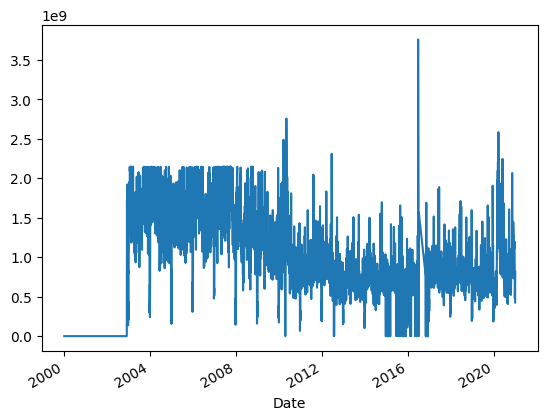

In [91]:
ax = ftse['Volume'].plot()
plt.show()


But we could plot based on another attribute if we wanted to.

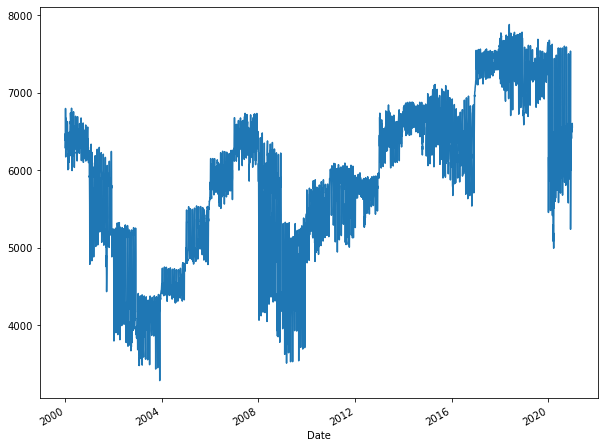

In [191]:
ftse['Close'].plot()
plt.show()


Let's focus on the most recent values. How could we do that?


By using slicing and specifying a range of dates. 

In [207]:
ftse['Close']['2-1-2020':].plot()
plt.show()

,Date,Open,High,Low,Close,Volume,Adjusted Close
Date,,,,,,,
2000-04-01,4/1/2000,6930.200000,6930.200000,6662.900000,6662.900000,0.0,0
2000-05-01,5/1/2000,6665.900000,6665.900000,6500.400000,6535.900000,0.0,0
2000-06-01,6/1/2000,6535.900000,6547.300000,6424.400000,6447.200000,0.0,0
2000-07-01,7/1/2000,6477.200000,6532.400000,6438.800000,6504.800000,0.0,0
2000-10-01,10/1/2000,6504.800000,6634.200000,6504.800000,6607.700000,0.0,0
...,...,...,...,...,...,...,...
2020-12-22,22/12/2020,NaN,NaN,NaN,NaN,NaN,0
2020-12-23,23/12/2020,6453.200195,6497.299805,6431.200195,6495.799805,807695400.0,0
2020-12-24,24/12/2020,6495.799805,6530.299805,6479.600098,6502.100098,477470700.0,0


So far the data have been presented in a daily basis. What if we wanted to choose a different frequency? Let's assume we wish to group the data into weekly data and display the last value for each week. 

You can read the [documentation](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.resample.html) for more options on this process

In [175]:
weekly_prices = ftse['Close'].resample('W').last()
weekly_prices.head()

Date
2000-01-02    6290.9
2000-01-09    6795.0
2000-01-16    6658.2
2000-01-23    6346.3
2000-01-30    6375.6
Freq: W-SUN, Name: Close, dtype: float64

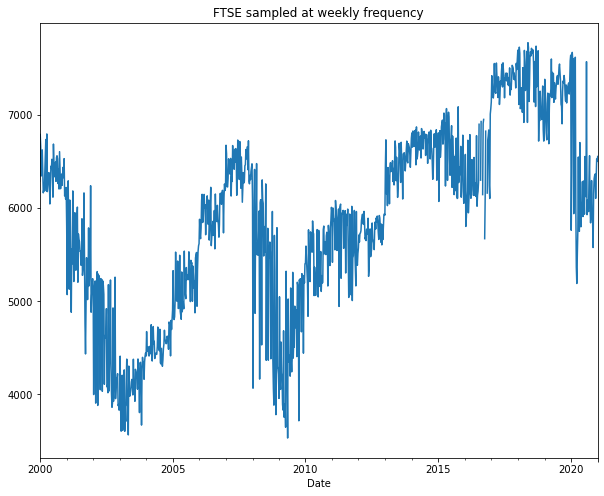

In [176]:
weekly_prices . plot ()
plt.title ('FTSE sampled at weekly frequency')
plt.show()


The previous snippets were focused on absolute prices. Frequently, we are more interested in the _returns_, that is the daily/weekly change in the absolute value. Furthermore, we prefer to focus on the _log returns_ You may wonder why this is the case. There are several resources explaining this. In the following I just provide a motivating example.

Assume that we have a +25\% return on one year followed by -20\% on the next one. That is, if we started with 100GBP, we had 125GBP the next year and 100GBP after the second year, i.e., we are back where we started from. If we care about returns over the 2-year period, we would be tempted to go $(0.25-0.2)/2 = 0.025$. Clearly, we didn't have such a profit over the 2-year period. While, if we care about log returns, we have $(\log(125/100)+\log(100/125))/2 = 0$. 

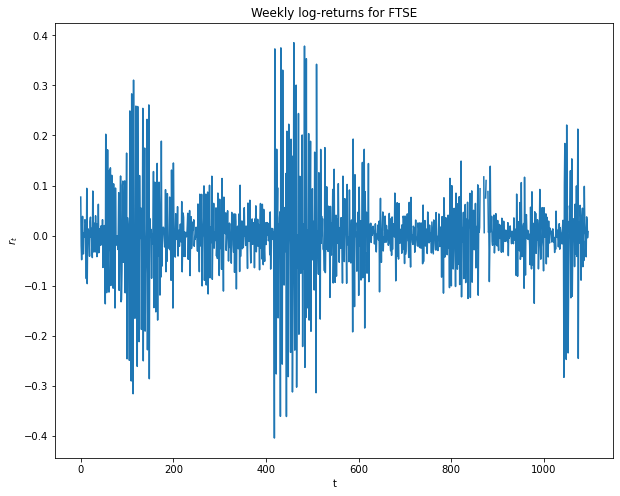

In [177]:
weekly_rets = np.diff(np.log(weekly_prices))
plt.plot(weekly_rets)
plt.xlabel('t'); plt.ylabel('$r_t$')
plt.title('Weekly log-returns for FTSE')
plt.show()


Notice that the $x$ axis in the plot above does not provide dates. This is since the _np.diff()_ function by definition retunrs an array, not a data-frame.

In [178]:
type(weekly_rets)

numpy.ndarray

In [179]:
weekly_rets_series = pd.Series(weekly_rets, index = weekly_prices.index[1:])
weekly_rets_series.head()

Date
2000-01-09    0.077083
2000-01-16   -0.020338
2000-01-23   -0.047977
2000-01-30    0.004606
2000-02-06    0.038583
Freq: W-SUN, dtype: float64

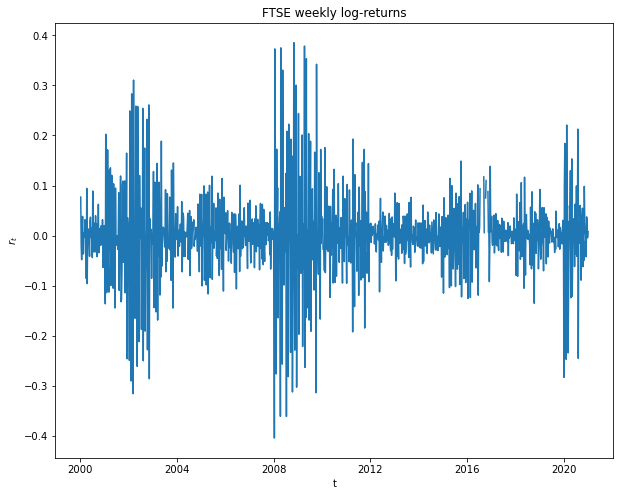

In [180]:
plt.plot(weekly_rets_series)
plt.title('FTSE weekly log-returns'); plt.xlabel('t'); plt.ylabel('$r_t$')
plt.show()

Below, we view the data according to different visualisation approaches

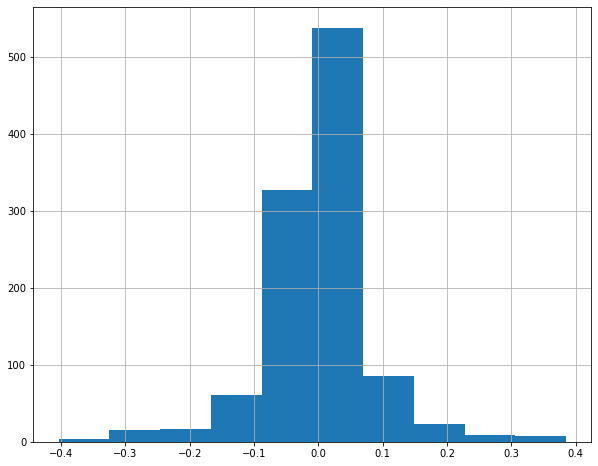

In [181]:
weekly_rets_series.hist()
plt.show()

In [182]:
weekly_rets_series.describe()

count    1085.000000
mean        0.000515
std         0.082205
min        -0.403668
25%        -0.024892
50%         0.001558
75%         0.026216
max         0.385105
dtype: float64

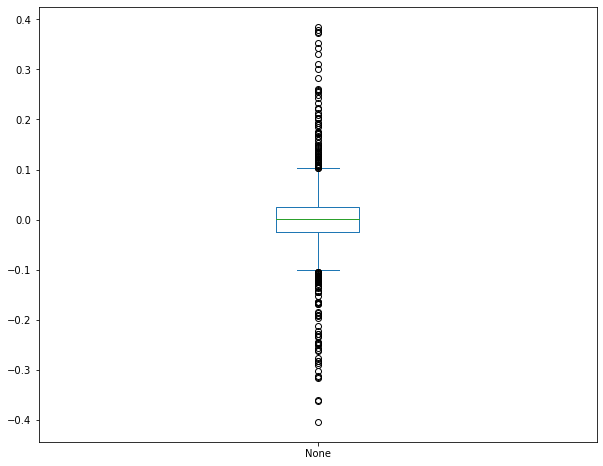

In [183]:
weekly_rets_series.plot.box()
plt.show()

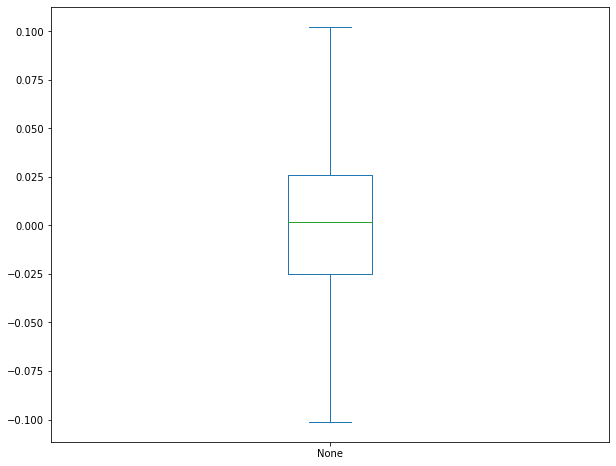

In [184]:
weekly_rets_series.plot.box(showfliers = False)
plt.show()

In [99]:
import numpy as np
ftse100 = pd.read_csv('data_lab2/FTSE100.csv')
ftse100.set_index(pd.to_datetime(ftse['Date'], format="%d/%m/%Y"), inplace = True)
ftse100.index[0]
#Year 2018 data
ftse2018 = ftse100[ftse100.index.year == 2018]
#weekly prices
weekly_prices = ftse2018['Close'].resample('W').last()

log_returns = np.diff(np.log(weekly_prices))
print("Mean: " + str(np.mean(log_returns)) + ",  Standard Deviation: " + str(np.std(log_returns)))






Mean: -0.002655105430998177,  Standard Deviation: 0.016997281921308404
